# Evaluation

This notebook implements all evaluation of rec-emb model results for the examined tasks.

## Disclaimer

The notebook handles a lot of special cases that occured during the developement. It should be only used with results from `recursive-embedding/DT/experiments/results`. Furthermore, this repository does not contain preprocessed token data for the IMDB corpus because of the dataset size. That may be relevant for BEST_RUNS evaluation (performance for individual records), but statistical data (lengths and depths) is still included.

## Setup

via [conda](https://docs.conda.io/en/latest/miniconda.html):
```bash
conda create -n stats python=2 pip numpy matplotlib pandas scipy scikit-learn seaborn jinja2 ipykernel
source activate stats
pip install bootstrapped
```

In [1]:

#%matplotlib notebook
%matplotlib inline
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import numpy as np
from scipy import stats as st
from scipy.sparse import coo_matrix
from scipy.stats import pearsonr
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

from math import sqrt
import shutil
import json
import os, sys, re
display(HTML("<style>.container { width:100% !important; }</style>"))
# display multiple dataframes next to each other
#CSS = """
#.output {
#    flex-direction: row;
#}
#"""
#HTML('<style>{}</style>'.format(CSS))

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

In [2]:

## Path to results directory, e.g. /PATH/TO/recursive-embeddings/DT/experiments/results
path = '/home/arne/recursive-embedding/DT/experiments/results'
## Path where all run data lives. 
## Only required if results should be fetched from a server (LOAD_DATA=True)
path_server = '/home/arne/recursive-embedding/DT/experiments/results'
## PATH/TO/HOST_COPRPORA_OUT (corpora_preprocessed)
## THIS HAS TO CONTAIN THE "STATS" FOLDERS (see subfolders of "recursive-embedding/docker/preprocessing/datasets_stats") 
#path_data = '/mnt/DATA/ML/data/corpora_preprocessed'
path_data = '/home/arne/recursive-embedding/docker/preprocessing/datasets_stats'

## select a task
task = 'RELATEDNESS/SICK'
#task = 'ENTAILMENT/SICK'
#task = 'SENTIMENT/IMDB'
#task = 'RE/SEMEVAL2010T8'
#task = 'RE_DEP/SEMEVAL2010T8'
## loads merged results from folder "ALL"
#task = 'ALL'
print('task: %s' % task)

## examine base variants: BOW vs. RNN vs. RecNN
TEST_BASE_MODELS = True
## examine RecNN variants: different linking, leaf node handling and map reduce swapping
TEST_BASE_VARIANTS = False

TEST_ALL_VALID = False

## examine impact of reduce function
TEST_RED = False
## examine impact of argument-lca centric structure 
TEST_LCA = False
## examine impact of conistency scoring models 
TEST_CS = False

TEST_COMPETITOR = False

## select best reduce function per task
SELECT_BEST_RED = True
## select best linkign method per task
SELECT_BEST_L = False

SELECT_SPLITS = None
#SELECT_SPLITS = ['0,1', '2,3', '4,5']
SELECT_LINKING = None
#SELECT_LINKING = 'DIRECT'
#SELECT_LINKING = 'EDGES'

SELECT_DIR_CLEAN = None
#SELECT_DIR_CLEAN = 'RNN'
SET_D_TO_T = None
#SET_D_TO_T = {'feat': ['-'], 'dir_clean': ['RECNN']}
SELECT_NOSPAN = True

## analyze best runs: check record wise performance
CHECK_BEST_RUNS = True

## load data from server
LOAD_DATA = False
SAVE_DF_DROPPED = False
server_adress = 'gpu' # defined in ~/.ssh/config
    
if TEST_BASE_MODELS or TEST_BASE_VARIANTS or TEST_ALL_VALID:
    SELECT_BEST_L = False
    SELECT_DIR_CLEAN = None
    SELECT_NOSPAN = True
    SELECT_LINKING = None
    SET_D_TO_T = None
    SELECT_SPLITS = None
if TEST_BASE_MODELS:
    TEST_BASE_VARIANTS = False
    SELECT_LINKING = 'DIRECT'
    if not task == 'ALL':
        SELECT_BEST_RED = False

if SELECT_BEST_L:
    SELECT_LINKING = None


parameters_final = ['model', 'linking', 'structure']
parameters_dev = ['model', 'linking', 'structure', 'st', 'fc', 'nfv', 'vvr', 'vvz', 'lr', 'kp', 'd']
metrics_general = ['time_s', 'steps_train', 'time_step_s']
#dev = not '/FINAL' in path 
dev = False
#best_only = True
best_only = False
print('dev=%s' % dev)
task_settings = {'RELATEDNESS/SICK': 
                     {'file': 'relatedness.tsv',
                      'metrics': ['test_pearson_r', 'test_mse', 'abs_error'] + metrics_general,
                      'metrics_dev': ['dev_best_pearson_r', 'dev_best_mse'] + metrics_general,
                      'parameters': parameters_dev if dev else parameters_final,
                      'data': {'DIRECT': 'SICK_RDF/corenlp_noner_recemb_mc2', 'EDGES': 'SICK_RDF/corenlp_noner_recemb_edges_mc2'},
                      'best_red': 'MAX',
                      'best_l': 'DIRECT',
                      'data_max': {'length': 50, 'depth': 20},
                      'best_competitor': {'map': '-', 'red': 'SUM'},
                     },
                    'ENTAILMENT/SICK': 
                     {'file': 'entailment.tsv',
                      'metrics': ['test_accuracy_t50'] + metrics_general,
                      'metrics_dev': ['dev_best_accuracy_t50'] + metrics_general,
                      'parameters': parameters_dev if dev else parameters_final,
                      'data': {'DIRECT': 'SICK_RDF/corenlp_noner_recemb_mc2', 'EDGES': 'SICK_RDF/corenlp_noner_recemb_edges_mc2'},
                      'best_red': 'SUM',
                      'best_l': 'EDGES',
                      'data_max': {'length': 50, 'depth': 20},
                      'best_competitor': {'map': 'GRU', 'red': '-'},
                     },
                  'SENTIMENT/IMDB': 
                     {'file': 'sentiment.tsv',
                      'metrics': ['test_accuracy_t50'] + metrics_general,
                      'metrics_dev': ['dev_best_accuracy_t50'] + metrics_general,
                      'parameters': parameters_dev if dev else parameters_final,
                      'filters_in': [{'sl': ['500']}, {'dpth': ['50']}],
                      'data': {'DIRECT': 'IMDB_RDF/corenlp_noner_recemb_mc20', 'EDGES': 'IMDB_RDF/corenlp_noner_recemb_edges_mc20'},
                      'best_red': 'MAX',
                      'best_l': 'EDGES',
                      'data_max': {'length': 500, 'depth': 50},
                      'best_competitor': {'map': 'GRU', 'red': '-'},
                     },
                  'RE/SEMEVAL2010T8':
                   {'file': 're_semeval2010t8.tsv',
                     'metrics': ['f1_macro', 'f1_wo_norelation_micro', 'test_f1_t33'] + metrics_general,
                     #'metrics': ['test_f1_t33', 'time_s'],
                     'metrics_dev': ['dev_best_f1_t33'] + metrics_general,
                     'metrics_alternative': {'dev_best_f1_t33': 'dev_best_recall@1', 'test_f1_t33': 'test_recall@1'},
                     'parameters': parameters_dev if dev else parameters_final,
                     #'filters_out': [{'dir_clean': ['RECNN_FULLTREE']}, {'m': ['LM:SUM-GRU', 'LM:MAX-GRU']}],
                     'filters_out': [{'a': ['EDG'], 'l': ['EDGES', 'DIRECT']}, 
                                     {'dir_clean': ['RECNN'], 'd': ['T']}, 
                                     {'feat': ['CS', 'CS-X', 'CS-IS', 'CS-IS-X'], 'd': ['F']},
                                     {'feat': ['BD-CS-IS-REG-WD', 'CS-REG', 'BD-CS-WD', 'BD-CS-REG', 'BD-CS', 'CS', 'BD-CS-REG-WD', 'BD-CS-IS-WD'], 'n': [3000]}
                                    ],
                     'data': {'DIRECT': 'SEMEVAL2010T8_RDF/corenlp_recemb_mc2_FULLTREE', 'EDGES': 'SEMEVAL2010T8_RDF/corenlp_recemb_edges_mc2',
                              'DIRECT_LCA': 'SEMEVAL2010T8_RDF/corenlp_recemb_mc2', 'EDGES_LCA': 'SEMEVAL2010T8_RDF/corenlp_recemb_edges_mc2_FIXED',
                              'SPAN': 'SEMEVAL2010T8_RDF/corenlp_recemb_span_mc2'},
                     'best_red': 'MAX',
                     'best_l': 'EDGES',
                     'data_max': {'length': 50, 'depth': 20},
                     'best_competitor': {'map': 'GRU', 'red': '-'},
                     },
                 'RE_DEP/SEMEVAL2010T8':
                   {'file': 're_dep_semeval2010t8.tsv',
                     'metrics': ['f1_macro', 'test_recall@1'] + metrics_general,
                     #'metrics': ['test_f1_t33', 'time_s'],
                     'metrics_dev': ['dev_best_f1_t33'] + metrics_general,
                     #'metrics_alternative': {'dev_best_f1_t33': 'dev_best_recall@1', 'test_f1_t33': 'test_recall@1'},
                     'parameters': parameters_dev if dev else parameters_final,
                     #'filters_out': [{'dir_clean': ['RECNN_FULLTREE']}, {'m': ['LM:SUM-GRU', 'LM:MAX-GRU']}],
                     'data': {'DIRECT': 'SEMEVAL2010T8_RDF/corenlp_recemb_mc2', 'EDGES': 'SEMEVAL2010T8_RDF/corenlp_recemb_edges_mc2_FIXED','SPAN': 'SEMEVAL2010T8_RDF/corenlp_recemb_span_mc2'},
                     'best_red': 'MAX',
                     'best_l': 'EDGES',
                     'data_max': {'length': 50, 'depth': 20},
                     },
                 'ALL':
                   {'file': 'ALL_BASE' if TEST_BASE_MODELS else 'ALL',
                      'metrics': ['metric_main'] + metrics_general,
                      #'metrics': ['test_f1_t33', 'time_s'],
                      'metrics_dev': None,
                      #'metrics_alternative': {'dev_best_f1_t33': 'dev_best_recall@1', 'test_f1_t33': 'test_recall@1'},
                      'parameters': parameters_dev if dev else parameters_final,
                      #'filters_out': [{'dir_clean': ['RECNN_FULLTREE']}, {'m': ['LM:SUM-GRU', 'LM:MAX-GRU']}],
                     'data': None,# {'DIRECT': 'SEMEVAL2010T8_RDF/corenlp_recemb_mc2', 'EDGES': 'SEMEVAL2010T8_RDF/corenlp_recemb_edges_mc2_FIXED','SPAN': 'SEMEVAL2010T8_RDF/corenlp_recemb_span_mc2'},
                     'best_red': 'MAX',
                     'best_l': 'EDGES',
                     },
                  #'RE/tacred':
                  # {'path': path + 're_tacred.tsv',
                  #    'metrics': ['test_f1_t33', 'time_s'],
                  #    'metrics_dev': ['dev_best_f1_t33', 'f1_wo_norelation_macro', 'f1_wo_norelation_micro', 'time_s'],
                  #    'metrics_alternative': {'dev_best_f1_t33': 'dev_best_recall@1', 'test_f1_t33': 'test_recall@1'},
                  #    'parameters': parameters_dev if dev else parameters_final,
                  #   },
                 }

#settings = {
    #'path': '/mnt/DATA/ML/experiments/FINAL/relatedness.tsv',
    #'path': '/mnt/DATA/ML/experiments/SEARCH/RE/SEMEVAL2010T8/re_semeval_search.tsv',
    #'path': '/mnt/DATA/ML/experiments/FINAL/entailment.tsv',
    #'metrics_task': ['pearson_r'],
    #'metrics': ['dev_best_f1_t33', 'time_s'],
    
    #'metrics_alternative': {'dev_best_f1_t33': 'dev_best_recall@1'},
    #'metric_dev': 'dev_best_pearson_r',
    #'parameters': ['data', 'te', ''], # entries from run_desc
    #'parameters': ['m', 'st', 'fc', 'dir', 'l', 'nfv', 'vvr', 'vvz']
    #'parameters':
    #'select': {'m': ['GRU', 'SUM-GRU']}
#}

task_setting = task_settings[task]
#path = '/mnt/DATA/ML/experiments/FINAL/relatedness.tsv'
#metrics_task = ['pearson_r']
fn = task_setting['file']
fn_path = os.path.join(path, fn)
print('fn_path: %s' % fn_path)

#metrics_task = settings['metrics_task']
if dev:
    metrics = task_setting['metrics_dev']
else:
    metrics = task_setting['metrics']
metric_main = metrics[0]
print('use metrics: %s' % metrics)
print('metric_main: %s' % metric_main)
metrics_alternative = task_setting.get('metrics_alternative', {})
parameters = task_setting['parameters']
print('use parameters: %s' % parameters)
select = task_setting.get('select', {})
metrics_inverted = ['time_s', 'steps_train', 'time_step_s']

metrics_dev = task_setting.get('metrics_dev', [])

best_red = task_setting.get('best_red', None)
print('best_red: %s' % best_red)
best_competitor = task_setting.get('best_competitor', None)
print('best_competitor: %s' % str(best_competitor))

data_max = task_setting.get('data_max', None)

filters_in = task_setting.get('filters_in', None)
filters_out = task_setting.get('filters_out', None)

task: RELATEDNESS/SICK
dev=False
fn_path: /home/arne/recursive-embedding/DT/experiments/results/relatedness.tsv
use metrics: ['test_pearson_r', 'test_mse', 'abs_error', 'time_s', 'steps_train', 'time_step_s']
metric_main: test_pearson_r
use parameters: ['model', 'linking', 'structure']
best_red: MAX
best_competitor: {'map': '-', 'red': 'SUM'}


In [3]:
# get result files from server
if LOAD_DATA and task != 'ALL':
    #assert path.endswith('/'), 'path has to end with "/" to copy files'
    if not path.endswith('/'):
        path += '/'
    print('copy file(s) to: %s' % path)
    # copy all files
    #!scp {server_adress}:'{path_server}*.tsv' {path}
    # copy only task file
    !scp {server_adress}:{path_server}{fn} {path}
    print('DONE')

In [4]:
def check_groups(df):
    grouped = df.groupby(COLUMN_RUN_DESC)
    temp = []
    for group_key in grouped.groups:
        
        group = grouped.get_group(group_key)
        if len(group) > 1:
            print('group_key: %s' % group_key)
            print(group)
            
            #temp.append(group)
            break
    #pd.concat(temp)
    #temp = pd.concat(temp)

In [5]:


if task != 'ALL':
    df_loaded = pd.read_csv(fn_path, sep='\t')
    print(len(df_loaded))


    #df_loaded.apply(lambda row: row['dev_best_recall@1'] or row['dev_best_f1_t33'],axis=1)
    for m_alt in metrics_alternative: 
        df_loaded[m_alt].fillna(df_loaded[metrics_alternative[m_alt]], inplace=True)

    def get_current_values(df):
        return {p: list(set(df[p])) for p in parameters}
    
    # fix double entries: keep only first run per path and run_description
    len_before_grouping = len(df_loaded)
    df_loaded = df_loaded.groupby(['run_description', 'path']).first().reset_index()
    print('keep only first runs per path and run_desc. keep: %i, removed: %i' % (len(df_loaded), len_before_grouping - len(df_loaded)))
    
    df_loaded['dir_clean'] = df_loaded['dir'].replace('\d+', '', regex=True)
    if task == 'RE/SEMEVAL2010T8':
        print('rename dir_clean entries: RECNN -> RECNN_LCA, RECNN_FULLTREE -> RECNN')
        indices_recnn = df_loaded[df_loaded['dir_clean'] == 'RECNN']
        indices_recnn_fulltree =  df_loaded[df_loaded['dir_clean'] == 'RECNN_FULLTREE']
        df_loaded.loc[df_loaded['dir_clean'] == 'RECNN', 'dir_clean'] = 'RECNN_LCA' #['RECNN_LCA'] * np.count_nonzero(indices_recnn)
        df_loaded.loc[df_loaded['dir_clean'] == 'RECNN_FULLTREE', 'dir_clean'] = 'RECNN'
        
        # overwrite LM with RECNN TODO: later use LM_LCA_NEW _> RECNN_LCA
        df_loaded.loc[df_loaded['dir_clean'] == 'LM_LCA_NEW', 'dir_clean'] = 'RECNN_LCA'
        #df_loaded = df_loaded[df_loaded['dir_clean'] != 'LM']
        #df_loaded['dir_clean'][indicesindices_recnn_fulltree_recnn] = 'RECNN'
    elif task == 'RE_DEP/SEMEVAL2010T8':
        df_loaded.loc[df_loaded['dir_clean'] == 'LM', 'dir_clean'] = 'RECNN_LCA'
    # exclude: dir==RECNN_FULLTREE
    #df_loaded = df_loaded[df_loaded['dir'] != 'RECNN_FULLTREE']
    #df_loaded.drop(df_loaded[df_loaded['dir'] == 'RECNN_FULLTREE'].index, axis=0, inplace=True)
    #df_loaded.reset_index(drop=True, inplace=True)
    if 'time_step_s' in metrics:
        if 'steps_train' in df_loaded and 'time_s' in df_loaded:
            print('create time_step_s from time_s and steps_train')
            df_loaded['time_step_s'] = df_loaded.apply(lambda row: row['time_s'] / row['steps_train'], axis=1)
        else:
            print('WARNING: could not create time_step_s from time_s and steps_train because one of them is missing')
else:
    df_loaded_list = []
    for fn in os.listdir(fn_path):
        fn_full = os.path.join(fn_path, fn)
        print('load: %s' % fn_full)
        df_loaded_temp = pd.read_pickle(fn_full)
        task_temp = fn.replace('-', '/')
        df_loaded_temp['task'] = task_temp
        #display(df_loaded_temp[:5])
        # defaults (for task != RE/SEMEVAL2018T8)
        if 'ct' not in df_loaded_temp:
            print('set ct=TREE for %s...' % fn)
            df_loaded_temp['ct'] = 'TREE'
        if 'dir_clean' not in df_loaded_temp:
            df_loaded_temp['dir_clean'] = 'RECNN'
        if 'd' not in df_loaded_temp:
            df_loaded_temp['d'] = 'F'
        if 'n' not in df_loaded_temp:
            df_loaded_temp['n'] = '10000'
        
        # take only entries with best reduction function
        if SELECT_BEST_RED:
            print('SELECT_BEST_RED is enabled')
            df_loaded_temp = df_loaded_temp[df_loaded_temp['red'].isin(['-', task_settings[task_temp]['best_red']])]
            
        if SELECT_BEST_L:
            print('SELECT_BEST_L is enabled')
            df_loaded_temp = df_loaded_temp[df_loaded_temp['l'] == task_settings[task_temp]['best_l']]
        
        df_loaded_list.append(df_loaded_temp)
    df_loaded = pd.concat(df_loaded_list, axis=0).fillna('-')
    run_desc_cols = ['n']
    
print('loaded %i records' % len(df_loaded))
    #set(df_loaded['dir_clean'])
display(df_loaded[:5])

#df_loaded.groupby('ct').count()
#set(df_loaded['ct'])

625
keep only first runs per path and run_desc. keep: 625, removed: 0
create time_step_s from time_s and steps_train
loaded 625 records


,run_description,path,abs_error,add_heads,dev_best_mse,dev_best_pearson_r,dev_file_indices,dir,run_desc,steps_train,test_mse,test_pearson_r,time_s,tree_embedder,dir_clean,time_step_s
0,aEDG_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBMC2_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/0,RELATEDNESS/SICK/DIRECT/RECNN,0.112033,EDG,0.021658,0.863250,"0,1",RECNN,aEDG_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBMC2_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF_spRECNN,1080,0.022428,0.855619,242.472485,HTU_reduceMAX_mapGRU_is,RECNN,0.224512
1,aEDG_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBMC2_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/0,RELATEDNESS/SICK/DIRECT/RECNN_WRONGAH,0.115369,NaN,0.022464,0.862018,"0,1",RECNN_WRONGAH,aEDG_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBMC2_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF_spWRONGAH,504,0.023349,0.851868,146.674638,HTU_reduceMAX_mapGRU_is,RECNN_WRONGAH,0.291021
2,aEDG_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBMC2_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/1,RELATEDNESS/SICK/DIRECT/RECNN,0.114443,EDG,0.022460,0.862756,"0,1",RECNN,aEDG_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBMC2_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF_spRECNN,684,0.023122,0.855931,186.242451,HTU_reduceMAX_mapGRU_is,RECNN,0.272284
3,aEDG_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBMC2_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/1,RELATEDNESS/SICK/DIRECT/RECNN_WRONGAH,0.116695,NaN,0.024064,0.851603,"0,1",RECNN_WRONGAH,aEDG_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBMC2_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF_spWRONGAH,540,0.023930,0.849259,149.493218,HTU_reduceMAX_mapGRU_is,RECNN_WRONGAH,0.276839
4,aEDG_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBMC2_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/2,RELATEDNESS/SICK/DIRECT/RECNN,0.112244,EDG,0.020686,0.869996,"0,1",RECNN,aEDG_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBMC2_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF_spRECNN,1044,0.022100,0.855971,235.713293,HTU_reduceMAX_mapGRU_is,RECNN,0.225779


In [6]:

#df_loaded[-5:]
#df_loaded.groupby('red').count()

#df_loaded[['tree_embedder', metrics[0]]].groupby('tree_embedder').count()
#df_loaded[df_loaded['tree_embedder'] == 'HTUBatchedHead_reduceMAX_mapGRU'][:10]
#set(df_loaded['dir_clean'])
#len(df_loaded[df_loaded['run_description'].str.contains('dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMULTICLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBEDGESMC2FIXED_teHTUREVREDUCEMAXMAPGRU_ccF_tfidfF_vvrF_vvzF')])
#df_loaded[~df_loaded['path'].str.contains('WRONG')][['path', 'run_description']].groupby(['run_description']).count()
#set(df_loaded['dir'])
if task == 'ALL':
    display(df_loaded.groupby(['ct', 'red', 'map', 'feat', 'task', 'l']).count())


In [7]:
COLUMN_RUN = 'run'
COLUMN_RUN_DESC_COLS = 'run_desc_cols'
COLUMN_DFIDX = 'dfidx'
COLUMN_RUN_DESC = 'run_description'
COLUMN_RUN_DESC_NEW = 'run_desc_new'

#map_value_short = {'CORENLPNONERRECEMBEDGESMC2': 'E', 
#             'CORENLPNONERRECEMBMC2': 'D',
#             #'HTUREDUCEMAXMAPGRU': 'MAX-GRU',
#             #'HTUREDUCESUMMAPGRU': 'SUM-GRU',
#             #'FLATGRU': 'GRU',
#             #'FLATSUM': 'SUM',
#             #'FLATMAX': 'MAX',
#            }
metrics_description = {'f1_macro': 'F1 macro', 'f1_wo_norelation_micro': 'F1 micro w/o no_relation', 'test_f1_t33': 'F1 micro', 'time_s': 'Time in s', 'test_accuracy_t50': 'Accuracy', 'test_pearson_r': "Pearson's r", 'test_mse': 'MSE'}
map_value_long = {'E': 'edges', 'D': 'direct'}
map_param_short = {'data': 'l', 'te': 'm', 'linking': 'l', 'model': 'm', 'structure': 'str'}
map_param_long = {'l': 'linking', 'm': 'model', 'str': 'structure', 'red': 'f_reduce', 'map': 'f_map'}
map_task_long = {'RTE': 'Rogognizing Textual Entailment', 'RP': 'Relatedness Prediction', 'SA': 'Sentiment Analysis', 'RE/semeval': 'Relation Extraction (SemEval)', 'RE/tacred': 'Relation Extraction (TacRED)'}
map_task_short = {'RE': 'RE', 'ENTAILMENT': 'RTE', 'RELATEDNESS': 'RP', 'SENTIMENT': 'SA'}
map_structure_to_order_awareness = {'BOW': 'NONE', 'RNN': 'FULL', 'RECNN': 'PARTLY'}
map_ct_to_order_awareness = {'TREE': 'PARTLY', 'FLAT': 'FULL'}
parameters = [map_param_short.get(p, p) for p in parameters]


def filter_iter(df, filters):
    for filter_dicts in filters:
        if isinstance(filter_dicts, dict):
            filter_dict_in = filter_dicts
            filter_dict_out = {}  
        else:
            filter_dict_in, filter_dict_out = filter_dicts
      
        filter_in = np.ones(len(df), dtype=bool)
        filter_out = np.zeros(len(df), dtype=bool)
        for k in filter_dict_in:
            filter_in = filter_in & df[k].isin(filter_dict_in[k])
        for k in filter_dict_out:
            filter_out = filter_out | df[k].isin(filter_dict_out[k])
        #filter_all = filter_all | (filter_in & filter_out)
        yield df[filter_in & ~filter_out], filter_dict_in, filter_dict_out

def format_description(v, vtype=None):
    if isinstance(v, list):
        return ', '.join([format_description(_v, vtype=vtype) for _v in v])
    
    #if vtype == 'm':
    if vtype == 'metric':
        return metrics_description[v]
    if vtype == 'parameter':
        return map_param_long[v]
    if vtype == 'task':
        return map_task_short[v.split('/')[0].upper()]
    if vtype == 'pass':
        return v
    if vtype == 'structure_to_order_awareness':
        return map_structure_to_order_awareness[v]
    if vtype == 'ct_to_order_awareness':
        return map_ct_to_order_awareness[v]
    raise AssertionError('unkown vtype=%s' % vtype)

def as_suffixes(v, suffixes):
    found = []
    for suffix in suffixes:
        if suffix in v:
            found.append(suffixes[suffix])
            v = v.replace(suffix, '')
    return v + (':' + '-'.join(found) if len(found) > 0 else '')

def format_model(m):
    if m.startswith('FLAT'):
        m = 'FLAT:' + m[len('FLAT'):]
    elif m.startswith('HTU'):
        m = m[len('HTU'):]
        m = m.replace('REDUCE','').replace('MAP','-')
        m = as_suffixes(m, {'REV':'REV', 'WD':'WD', 'IS':'IS', 'PL':'PL'})
        if m.startswith('BATCHEDHEADX'):
            m = 'LM:' + m[len('BATCHEDHEADX'):] + (':' if len(m.split(':')) == 1 else '-') + 'REG'
        elif m.startswith('BATCHEDHEAD'):
            m = 'LM:' + m[len('BATCHEDHEAD'):]
        else:
            m = 'TREE:' + m
       
    return m

def format_data(v):
    if 'SPAN' in v:
        return 'SPAN'
    if 'EDGES' in v:
        return 'EDGES'
    return 'DIRECT'

def get_value_short(v, t=None):
    res = v
    #try:
    #    float(v)
    #    return v
    #except ValueError:
    #    pass
     
    if isinstance(res, str):
        if t == 'te':
            res = format_model(res)
        elif t == 'data':
            res = format_data(v)
        elif t == 'mt':
            if v.upper() in ['MULTICLASS', 'MCLASS']:
                res = 'CLASS'
            else:
                res = v
        else:
            parts = res.split('-')
            if parts[0] != '':
                res = ','.join(parts)
        #res = format_model(res)
        
    return res

def get_structure_type(v):
    if v.startswith('TREE:'):
        return 'RECNN'
    if v.startswith('LM'):
        return 'LM'
    if v.startswith('FLAT:'):
        if v.startswith('FLAT:GRU') or v.startswith('FLAT:LSTM'):
            return 'RNN'
        if v.startswith('FLAT:SUM') or v.startswith('FLAT:MAX'):
            return 'BOW'
        raise AssertionError('unknown flat model: %s' % v)
    raise AssertionError('unknown model: %s' % v)

def value_to_string(v):
    return str(v).replace(',', '-').upper()

def run_desc_to_string(run_desc_dict, keys=None):
    if keys is None:
        keys = sorted(list(run_desc_dict))
    return '_'.join([k + value_to_string(run_desc_dict[k]) for k in keys])

def run_desc_to_dict(run_desc):
    _res = {}
    parts = run_desc.split('/')
    if len(parts) == 2:
        _res[COLUMN_RUN] = parts[1]
    elif len(parts) > 2:
        print('WARNINING: more then 2 parts for split with "/": %s' % run_desc)
    else:
        print('WARNINING: no split_idx found: %s' % run_desc)
    run_desc = parts[0]
    parts = re.split(r'(_|^)([a-z]+)', run_desc)
    #new_entries = {parts[i-1]: ','.join(parts[i].strip().split('-')) for i in range(3, len(parts), 3)}
    new_entries = {map_param_short.get(parts[i-1], parts[i-1]): get_value_short(parts[i], parts[i-1]) for i in range(3, len(parts), 3)}
    _res.update(new_entries)
    cols_run_desc = sorted([k for k in new_entries if k not in [COLUMN_RUN, COLUMN_DFIDX]])
    _res[COLUMN_RUN_DESC_NEW] = run_desc_to_string(_res, keys=cols_run_desc)
    _res[COLUMN_RUN_DESC_COLS] = ','.join(cols_run_desc)
    #_res[COLUMN_RUN_DESC_NEW] = '_'.join([col + _res[col] for col in cols_run_desc])
    
    return _res

#run_desc_to_dict('a_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBEDGESMC2_teHTUREDUCESUMMAPGRU_ccF_tfidfF_vvrF_vvzF/0')
#pd.DataFrame(df['run_description'].apply(run_desc_to_dict))#, axis=1, result_type='expand')


def model_to_features(model):
    res = {}
    parts = model.split(':')
    
    #res['rm'] = parts[1]
    feats = []
    if len(parts) > 2:
        feats = parts[2].split('-')
    
    # save LM (language model) as CS (consistency scoring) feature
    if parts[0] == 'LM':
        feats.append('CS')
        res['ct'] = 'TREE'
    else:
        res['ct'] = parts[0]
    
    if len(feats) == 0:
        res['feat'] = '-'
    else:
        res['feat'] = '-'.join(sorted(feats))
    res['map'] = '-'
    for mf in ['GRU', 'LSTM']:
        if mf in parts[1]:
            res['map'] = mf
            break
    res['red'] = '-'
    for rf in ['MAX', 'AVG', 'SUM']:
        if rf in parts[1]:
            res['red'] = rf
            break
    
    return res

def get_filter(df, filter_dict):
    bool_filter = np.ones(len(df_all), dtype=bool)
    for filter_key in filter_dict:
        bool_filter = bool_filter & df[filter_key].isin(filter_dict[filter_key])
    print('filter: %s. select %i of %i rows' % (filter_dict, np.count_nonzero(bool_filter), len(df)))
    return bool_filter

def fix_feat(feat):
    feat_parts = [fe for fe in feat.split('-') if fe !='']
    if len(feat_parts) == 0:
        return '-'
    return '-'.join(sorted(feat_parts))

if task != 'ALL':
    df_runddesc = pd.DataFrame([run_desc_to_dict(rd) for rd in df_loaded[COLUMN_RUN_DESC]])
    df_model = pd.DataFrame([model_to_features(rd) for rd in df_runddesc['m']])
    take_columns = list(metrics) + ['dir_clean', 'dir', 'path', COLUMN_RUN_DESC]
    for m in task_setting['metrics_dev']:
        if m not in metrics:
            take_columns.append(m)
    df_all = pd.concat([df_model, df_loaded[take_columns], df_runddesc], axis=1)
    df_all['str'] = df_all.apply(lambda row: get_structure_type(row['m']), axis=1)
    
    # set directionality to True, if WD (distinct mappings for directionaility enforce d=True internally)
    df_all.loc[df_all['feat'].str.contains('WD'), 'd'] = 'T'

    if best_only:
        print('keep only runs with max %s ...' % task_setting['metrics_dev'])
        n = len(df_all)
        df_all = df_all.sort_values(task_setting['metrics_dev'], ascending=False).drop_duplicates(['run_desc', 'run'])
        print('removed %i of %i runs (%i remaining)' % (n - len(df_all), n, len(df_all)))
    else:
        print('loaded %i runs' % len(df_all))
    
   
    # remove (wrong) entries with max metric 
    df_all = df_all[df_all[metrics[0]] < 1.0]
    if filters_in is not None:
        print('use filters_in: %s' % filters_in)
        bool_filter = np.zeros(len(df_all), dtype=bool)
        for filter_in in filters_in:
            bool_filter = bool_filter | get_filter(df_all, filter_in)
        df_all = df_all[bool_filter]

    if filters_out is not None:
        print('use filters_out: %s' % filters_out)
        bool_filter = np.zeros(len(df_all), dtype=bool)
        for filter_out in filters_out:
            bool_filter = bool_filter | get_filter(df_all, filter_out)
        df_all = df_all[~bool_filter]
        

    df_all.reset_index(drop=True, inplace=True)
    print('%i records remain' % len(df_all))
    
    #print(set(df_all['l']))

    run_desc_cols = df_all[COLUMN_RUN_DESC_COLS][0].split(',')
    # move model column to front
    run_desc_cols.insert(0, run_desc_cols.pop(run_desc_cols.index('m')))
    print('run_desc_cols: %s' % run_desc_cols)
    df_all.drop(columns=[COLUMN_RUN_DESC_COLS], inplace=True)
    
         # take only entries with bets reduction function
    if SELECT_BEST_RED:
        df_all = df_all[df_all['red'].isin(['-', task_settings[task]['best_red']])]

    if SELECT_BEST_L:
        df_all = df_all[df_all['l'] == task_settings[task]['best_l']]
    
    df_all.reset_index(drop=True, inplace=True)
    
    for col in df_all:
        if len(df_all) == len(df_all[df_all[col].isnull() | (df_all[col] == '')]):
            print('delete col "%s", it contains only nan / empty values' % col)
            df_all.drop(columns=[col], inplace=True)

    
    # add BD for d==True (RECNN_LCA only!)
    indices = ((df_all['dir_clean'] == 'RECNN_LCA') & (df_all['d'] == 'T')) | (df_all['feat'].str.contains('WD'))
    df_all.loc[indices, 'feat'] = df_all.loc[indices, 'feat'] + '-BD'
    df_all.drop(columns='d', inplace=True)    
    indices = (df_all['dir_clean'] == 'RECNN_LCA') & (~df_all['feat'].str.contains('CS'))
    df_all.loc[indices, 'feat'] = df_all.loc[indices, 'feat'] + '-LCA'
    df_all.loc[indices, 'dir_clean'] = 'RECNN'
    df_all['feat'] = df_all.apply(lambda row: fix_feat(row['feat']), axis=1)

else:
    df_all = df_loaded

df_all[:5]


loaded 625 runs
625 records remain
run_desc_cols: ['m', 'a', 'avf', 'b', 'bs', 'cc', 'clp', 'cm', 'cntxt', 'd', 'dpth', 'dt', 'ec', 'fc', 'kp', 'kpb', 'kpn', 'l', 'lc', 'leaffc', 'lr', 'mt', 'n', 'nfv', 'ns', 'rootfc', 'sl', 'sm', 'st', 'tfidf', 'tk', 'vvr', 'vvz']
delete col "ec", it contains only nan / empty values
delete col "fc", it contains only nan / empty values
delete col "sm", it contains only nan / empty values
delete col "tk", it contains only nan / empty values


/home/arne/miniconda2/envs/stats/lib/python2.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,ct,feat,map,red,test_pearson_r,test_mse,abs_error,time_s,steps_train,time_step_s,dir_clean,dir,path,run_description,dev_best_pearson_r,dev_best_mse,a,avf,b,bs,cc,clp,cm,cntxt,dfidx,dpth,dt,kp,kpb,kpn,l,lc,leaffc,lr,m,mt,n,nfv,ns,rootfc,run,run_desc_new,sl,st,tfidf,vvr,vvz,str
0,TREE,IS,GRU,MAX,0.855619,0.022428,0.112033,242.472485,1080,0.224512,RECNN,RECNN,RELATEDNESS/SICK/DIRECT/RECNN,aEDG_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBMC2_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/0,0.863250,0.021658,EDG,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,"0,1",20,F,0.9,1.0,1.0,DIRECT,-1,0,0.001,TREE:MAX-GRU:IS,SIMTUPLE,10000,F,20,300,0,aEDG_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU:IS_mtSIMTUPLE_n10000_nfvF_ns20_rootfc300_sl50_sm_st150_tfidfF_tk_vvrF_vvzF,50,150,F,F,F,RECNN
1,TREE,IS,GRU,MAX,0.851868,0.023349,0.115369,146.674638,504,0.291021,RECNN_WRONGAH,RECNN_WRONGAH,RELATEDNESS/SICK/DIRECT/RECNN_WRONGAH,aEDG_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBMC2_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/0,0.862018,0.022464,EDG,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,"0,1",20,F,0.9,1.0,1.0,DIRECT,-1,0,0.001,TREE:MAX-GRU:IS,SIMTUPLE,10000,F,20,300,0,aEDG_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU:IS_mtSIMTUPLE_n10000_nfvF_ns20_rootfc300_sl50_sm_st150_tfidfF_tk_vvrF_vvzF,50,150,F,F,F,RECNN
2,TREE,IS,GRU,MAX,0.855931,0.023122,0.114443,186.242451,684,0.272284,RECNN,RECNN,RELATEDNESS/SICK/DIRECT/RECNN,aEDG_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBMC2_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/1,0.862756,0.022460,EDG,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,"0,1",20,F,0.9,1.0,1.0,DIRECT,-1,0,0.001,TREE:MAX-GRU:IS,SIMTUPLE,10000,F,20,300,1,aEDG_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU:IS_mtSIMTUPLE_n10000_nfvF_ns20_rootfc300_sl50_sm_st150_tfidfF_tk_vvrF_vvzF,50,150,F,F,F,RECNN
3,TREE,IS,GRU,MAX,0.849259,0.023930,0.116695,149.493218,540,0.276839,RECNN_WRONGAH,RECNN_WRONGAH,RELATEDNESS/SICK/DIRECT/RECNN_WRONGAH,aEDG_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBMC2_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/1,0.851603,0.024064,EDG,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,"0,1",20,F,0.9,1.0,1.0,DIRECT,-1,0,0.001,TREE:MAX-GRU:IS,SIMTUPLE,10000,F,20,300,1,aEDG_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU:IS_mtSIMTUPLE_n10000_nfvF_ns20_rootfc300_sl50_sm_st150_tfidfF_tk_vvrF_vvzF,50,150,F,F,F,RECNN
4,TREE,IS,GRU,MAX,0.855971,0.022100,0.112244,235.713293,1044,0.225779,RECNN,RECNN,RELATEDNESS/SICK/DIRECT/RECNN,aEDG_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBMC2_teHTUREDUCEMAXMAPGRUIS_ccF_tfidfF_vvrF_vvzF/2,0.869996,0.020686,EDG,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,"0,1",20,F,0.9,1.0,1.0,DIRECT,-1,0,0.001,TREE:MAX-GRU:IS,SIMTUPLE,10000,F,20,300,2,aEDG_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU:IS_mtSIMTUPLE_n10000_nfvF_ns20_rootfc300_sl50_sm_st150_tfidfF_tk_vvrF_vvzF,50,150,F,F,F,RECNN


In [8]:
print('all features: %s' % set(df_all['feat']))



all features: set(['REV', 'IS', '-', 'PL'])


In [9]:
def _norm(v):
    _min = v.min()
    _max = v.max()
    if _min == _max:
        return np.ones_like(v) * 0.5
    return (v - _min) / (_max - _min)

def color_to_hex(rgba):
    return '#%02x%02x%02x%02x' % (rgba[0]*255,rgba[1]*255,rgba[2]*255,rgba[3]*255)

#def set_white_if_max(vm _max)
#    if 

def colormap_columns(data, cm=sns.light_palette("green", as_cmap=True), columns=metrics, columns_inverted=metrics_inverted, columns_dont_exp=None):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    #print(type(data.name))
    name_main = data.name
    if isinstance(name_main, tuple):
        name_main = name_main[0]
    if columns is not None and name_main not in columns or len(data) <= 1:
        return [''] * len(data)
    
    _data = data.values.astype(float)
    filter_not_nan = ~data.isnull()
    
    if name_main in columns_inverted:
        _data = -data
    data_norm = _norm(_data[filter_not_nan])
    #print(len(_data))
    #print(len(data_norm))
    # rescale exponentially
    if columns_dont_exp is None:
        columns_dont_exp = columns_inverted
    if name_main not in columns_dont_exp: 
        data_norm_scaled = _norm(np.exp(data_norm))
        #print('\trescaled %s for coloring. total dif: %f' % (data.name, np.absolute(data_norm - data_norm_scaled).sum()))
        data_norm = data_norm_scaled
    _max = data_norm.max()
    data_norm_all = np.zeros(len(_data), dtype=data_norm.dtype)
    data_norm_all[filter_not_nan] = data_norm
    # ', color: white' if v == _max else ''
    # 
    return ['background-color: {}'.format(color_to_hex(cm(v))) if not data.isnull()[i] else 'background-color: white' for i, v in enumerate(data_norm_all)]

def max_white(s, columns=None, columns_inverted=metrics_inverted, margin=0.05):
    '''
    Color the maximum in a Series white. Respects columns_inverted and takes a margin value.
    '''
    name_main = s.name
    if isinstance(name_main, tuple):
        name_main = name_main[0]
    if (columns is not None and name_main not in columns) or len(s) <= 1 or not np.issubdtype(s.dtype, np.number):
        return [''] * len(s)
    values = s.values
    filter_not_nan = ~s.isnull()
    if name_main in columns_inverted:
        #print('invert color for col=%s (%s)' % (s.name, columns_inverted))
        values = -values
    values_normed = _norm(values[filter_not_nan])
    set_white = values_normed * (1.0 + margin) >= values_normed.max()
    set_white_all = np.zeros(len(s), dtype=set_white.dtype)
    set_white_all[filter_not_nan] = set_white
    #    set_white = s <= (s.min() + s.std())
    #else:
    #    set_white = s >= (s.max() - s.std())
    return ['color: white' if v else '' for v in set_white_all]

def display_colored(df, columns_inverted=metrics_inverted, columns=('mean_a', 'mean_b')):
    if columns is None:
        columns = list(df)
    float_cols = [col for col in df if df[col].dtype in [np.float64, np.float32]]
    #print(float_cols)
    #formatter = lambda x: "{:.4f}".format(x) if isinstance(x,(flomax_whiteat, np.float)) else x
    formatter = {col: '{:.4f}' for col in float_cols}
    res = df.style.apply(colormap_columns, columns=columns, columns_inverted=columns_inverted, axis=0).apply(max_white, columns=columns, columns_inverted=columns_inverted, axis=0).format(formatter)
    display(res)

In [10]:
def swap_stats(df, change_column='change'):
    df = pd.DataFrame(df)
    
    conv = {idx: '(' + ' -> '.join(idx[1:-1].split(' -> ')[::-1]) + ')' for idx in df.index.get_level_values(change_column)}
    df.rename(index=conv, level=change_column, inplace=True)
    
    for a, b in [('mean_a', 'mean_b'), ('nbr_a', 'nbr_b')]:
        temp =df[a].copy()
        df[a] = df[b]
        df[b] = temp
        #df = df.rename(columns = {a:b})#, inplace = True)
    for col in ['dif', 'dif_%']:
        df[col] = df[col] * -1.0
    
    #df.set_index(df.index.droplevel('change'), inplace=True)
    return df
        
def display_stats(df, metric, sort_by, index_contains=None):
    
    if metric in metrics_inverted:
        _df_dec = df[df['dif'] > 0]
        _df_inc = df[df['dif'] < 0]
        _columns_inverted=['mean_a', 'mean_b']
    else:
        _df_dec = df[df['dif'] < 0]
        _df_inc = df[df['dif'] > 0]
        _columns_inverted=[]
    if 'change' in df.index.names:
        _df_dec_swapped = swap_stats(_df_dec)
        _df_all = pd.concat([_df_dec_swapped, _df_inc])
        if sort_by is not None:
            _df_all = _df_all.sort_values(sort_by)
        
        if hasattr(_df_all.index, 'names') and 'task' in _df_all.index.names:
            #print('create pivot for tasks...')
            _df_all = _df_all[_df_all.index.get_level_values('task')  != '@']
            #_df_all = _df_all.unstack(level='task')
            
        if index_contains is not None:
            for k in index_contains:
                _df_all = _df_all[_df_all.index.get_level_values(k).str.contains(index_contains[k])]
        print('increase of %s:' % metric)
        display_colored(_df_all, columns_inverted=_columns_inverted, columns=('mean_a', 'mean_b', 'dif_%'))        
    else:
        if sort_by is not None:
            _df_dec = _df_dec.sort_values(sort_by)
            _df_inc = _df_inc.sort_values(sort_by)
        if hasattr(_df_dec.index, 'names') and 'task' in _df_dec.index.names:
        #    print('create pivot for tasks...')
            _df_dec = _df_dec[_df_dec.index.get_level_values('task')  != '@']
        #    _df_dec = _df_dec.unstack(level='task')
        print('decrease of %s:' % metric)
        display_colored(_df_dec, columns_inverted=_columns_inverted, columns=('mean_a', 'mean_b', 'dif_%'))
        
        if hasattr(_df_inc.index, 'names') and 'task' in _df_inc.index.names:
        #    print('create pivot for tasks...')
            _df_inc = _df_inc[_df_inc.index.get_level_values('task')  != '@']
        #    _df_inc = _df_inc.unstack(level='task')
        print('increase of %s:' % metric)
        display_colored(_df_inc, columns_inverted=_columns_inverted, columns=('mean_a', 'mean_b', 'dif_%'))

        

def reformat_ttest_dict(t_test_results, metric, index_names, index_split='/', sort_by=None, sort_reverse=False, dont_show_all=False, pivot_table_columns=None, index_contains=None):
    results_df = pd.DataFrame.from_dict(t_test_results,orient='Index')
    results_df.columns = ['statistic','pvalue', 'mean_a', 'mean_b', 'nbr_a', 'nbr_b']
    #display(results_df)
    #print(results_df.index.values)
    #print([idx.split(index_split) for idx in results_df.index.values])
    print
    print(index_names)
    results_df.index = pd.MultiIndex.from_tuples([idx.split(index_split) for idx in results_df.index.values], names=index_names)
    
    if not dont_show_all:
        if 'metric' in index_names:
            display(results_df.xs(metric, level='metric').sort_index())
        else:
            display(results_df.sort_index())

    #m = metrics[0]
    #best_settings[m][parameters].sort_values(by=p)

    #display(pd.DataFrame(best_settings[m][[m] + parameters].sort_values(by=p)[m].values - second_settings[m][[m] + parameters].sort_values(by=p)[m].values))
    #display(best_settings[m][parameters].sort_values(by=p))
    #display(second_settings[m][parameters].sort_values(by=p))

    #results_df.xs('dev_best_f1_t33', level='metric')
    results_df['dif'] = results_df.apply(lambda row: row['mean_b'] - row['mean_a'], axis=1)
    results_df['dif_%'] = results_df.apply(lambda row: (row['dif'] / row['mean_a']), axis=1)
    results_df['a.05'] = results_df.apply(lambda row: row['pvalue'] < 0.05, axis=1)
    results_df['a.01'] = results_df.apply(lambda row: row['pvalue'] < 0.01, axis=1)
    results_df['a.001'] = results_df.apply(lambda row: row['pvalue'] < 0.001, axis=1)
    #x = results_df.xs(metrics[0], level='metric').sort_values('dif_%')
    #x = x.iloc[(-np.abs(x['dif_%'].values)).argsort()]
    #x = x.xs(metrics[0], level='v')
    #x = results_df.reset_index()
    x = results_df
    if 'metric' in index_names:
        #x = x[x['metric'] == metric]
        x = x.xs(metric, level='metric')
    
    # x.set_index(index_names, drop=True, inplace=True)
    
    #x = x[x['v'].str.startswith('TREE')]
    #x = x[x['sub_p'] == 'st']
    #x = x[(x['nbr_a'] >= 5) & (x['nbr_b'] >= 5)]
    #x = x[x[]]
    #cols_color = ['dif' 'dif_%', 'mean_a', 'mean_b']
    
    print('\nsignificant changes:')
    display_stats(df=x[x['a.05']], metric=metric, sort_by=sort_by, index_contains=index_contains)
    
    print('\nNOT significant changes:')
    display_stats(df=x[~x['a.05']], metric=metric, sort_by=sort_by, index_contains=index_contains)

    
    if pivot_table_columns is not None:
        row_col, col_col, value_col = pivot_table_columns
        x_p = x[x['a.01']]
        #vals = x_pt[value_col].values
        #cols = x_pt[col_col].tolist()
        #rows = x_pt[row_col].tolist()
        #all_labels = sorted(list(set(cols + rows)))
        #labels_map = {l: i for i, l in enumerate(all_labels)}
        #coo = coo_matrix((vals, ([labels_map[l] for l in rows], [labels_map[l] for l in cols])), shape=(len(all_labels), len(all_labels)))
        #print(coo.toarray())
        
        pt = pd.pivot_table(x_p, values=value_col, index=[row_col], columns=[col_col])#, fill_value=0)

        #display(pt.style.background_gradient(cmap='summer').highlight_null('grey'))
        #cm = sns.light_palette("green", as_cmap=True)
        cm = sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)
        #cm = ListedColormap(sns.color_palette("BrBG", 7).as_hex())
        
        display(pt.style.background_gradient(cmap=cm).highlight_null('grey'))
 
def series_depend_on(series_a, series_b):
    if len(series_a) != len(series_b):
        return False
    d_a = {}
    d_b = {}
    for i in range(len(series_a)):
        val_a = series_a.iloc[i]
        val_b = series_b.iloc[i]
        if d_a.setdefault(val_a, val_b) != val_b:
            return False
        if d_b.setdefault(val_b, val_a) != val_a:
            return False
        
    return True

def get_mergeable_cols(df):
    # TODO: merge columns 
    _col_names = list(df)
    _values_nbrs = {}
    _merged_ids = {}
    #
    for i, cn_a in enumerate(_col_names):
        for cn_b in _col_names[i+1:]:
            if series_depend_on(df[cn_a], df[cn_b]):
                #print('merge: %s + %s' % (cn_a, cn_b))
                _l = len(_merged_ids)
                _idx_a = _merged_ids.get(cn_a, _l)
                _idx_b = _merged_ids.get(cn_b, _l)
                if _idx_a != _l and _idx_b != _l:
                    if _idx_a != _idx_b:
                        print('merge sets')
                        # merge cluster _idx_a and _idx_b
                        for k in list(_merged_ids):
                            if _merged_ids[k] == _idx_b:
                                _merged_ids[k] = _idx_a                            
                elif _idx_a != _l:
                    _merged_ids[cn_b] = _idx_a
                elif _idx_b != _l:
                    _merged_ids[cn_a] = _idx_b
                else:
                    _merged_ids[cn_b] = _idx_a
                    _merged_ids[cn_a] = _idx_b
    _merged_sets = {}
    for cn in _merged_ids:
        _merged_sets.setdefault(_merged_ids[cn], []).append(cn)

    return _merged_sets, _merged_ids

def drop_and_merge_cols(df, dominant = ['ct', 'l', 'map', 'str'], keep=()):
        
    merged_col_sets, merged_col_ids = get_mergeable_cols(df)
    drop_cols = []
    drop_cols_not_unique = []
    for col_id in merged_col_sets:
        col_list = merged_col_sets[col_id]
        if len(set(df_filtered[col_list[0]])) <= 1:
            print('drop col set: %s' % (col_list))
            drop_cols.extend(col_list)
        else:
            print('keep col set: %s' % (col_list))
            found = False
            for d in dominant:
                if d in col_list:
                    col_list.remove(d)
                    print('keep: %s for %s' % (d, col_list))
                    drop_cols_not_unique.extend(col_list)
                    found = True
                    break
            if not found:
                print('WARNING: no dominant value found for: %s' % col_list)
    print('drop one entry cols:')
    display(pd.DataFrame([df_filtered[drop_cols].iloc[0]]))
    
    print('dont drop, because in keep: %s' % [c for c in drop_cols if c in keep])
    df = df.drop(columns=[c for c in drop_cols if c not in keep])
    print('drop not unique (but dependent) cols: %s' % drop_cols_not_unique)
    print('dont drop, because in keep: %s' % [c for c in drop_cols_not_unique if c in keep])
    df = df.drop(columns=[c for c in drop_cols_not_unique if c not in keep])
    
    return df

def parse_par_count_line(line):
    par_count = line.split(' DEBUG ')[1].strip()
    if par_count.startswith('(trainable)'):
        trainable = True
    elif par_count.startswith('(not trainable)'):
        trainable = False
    par_count = par_count.split('trainable) ')[1]
    parts = par_count.split(' parameter count: ')
    return parts[0].replace(' ', ''), trainable, int(parts[1])

def get_parameter_data_from_log(fn):
    par_all = {}
    with open(fn) as f:
        lines = f.readlines()
        
        for i, line in enumerate(lines):
            if 'parameter count:' in line:
                par_type, trainable, par_nbr = parse_par_count_line(line)
                par_count_detail = json.loads(lines[i+1].split(' DEBUG ')[1].strip().replace("'", '"'))
                #if par_count.startswith('reverse parameter count') and par_count
                
                if par_type != 'reverse':# and par_nbr != 0:
                    #print('\t%s\t%s\t%i' % (par_type, trainable, par_nbr))
                    #print('\t%s' % par_count_detail)
                    #par_all['%s_%s' % (par_type, trainable)] = (par_nbr, par_count_detail)
                    if par_nbr > 0:
                        par_all['params_%s_%s_nbr' % (par_type, 'train' if trainable else 'fix')] = par_nbr
                        par_all['params_%s_%s_details' % (par_type, 'train' if trainable else 'fix')] = par_count_detail
    return par_all

def to_front(l, elem):
    l.insert(0, l.pop(l.index(elem)))
    
def boxplot_sorted(df, by, column, reverse=False, *args,  **kwargs):
    df_current_grouped = df.groupby(by)
    df_temp = pd.DataFrame({col:vals[column] for col,vals in df_current_grouped})
    means = df_temp.mean().sort_values(ascending=not reverse)
    df_temp = df_temp[means.index]
    df_temp.boxplot(*args, **kwargs)

In [11]:

if task == 'ALL':
    df_all.groupby(['red', 'map', 'feat', 'task', 'l']).count()


# Filter

In [12]:
pd.set_option('display.max_colwidth', -1)

# FILTER columns
df_all_filter = [True] * len(df_all)
# errornous runs
df_all_filter = df_all_filter & ~df_all['dir_clean'].isin(['RECNN_WRONGAH', 'LM_WRONGAH','RNN_NOARGS', 'BOW_NOARGS'])

if SELECT_NOSPAN:
    if 'l' in df_all:
        df_all_filter = df_all_filter & ~df_all['l'].isin(['SPAN'])

# base models
if TEST_BASE_MODELS:
    if 'd' in df_all:
        df_all_filter = df_all_filter & (df_all['d'] == 'F')
    df_all_filter = df_all_filter & df_all['feat'].isin(['-'])
    if 'l' in df_all:
        df_all_filter = df_all_filter & df_all['l'].isin(['DIRECT'])
    df_all_filter = df_all_filter & ~df_all['dir_clean'].isin(['RECNN_LCA'])

#display(df_all.loc[df_all_filter,:].groupby(['red', 'map', 'feat', 'task', 'l']).count())
    
if TEST_CS:
    df_all_filter = df_all_filter & df_all['feat'].str.contains('CS')
else:
    df_all_filter = df_all_filter & ~df_all['feat'].str.contains('CS')
    
if TEST_BASE_VARIANTS:
    df_all_filter = df_all_filter & ~df_all['feat'].str.contains('LCA') & ~df_all['feat'].str.contains('CS')

if TEST_LCA:
    df_all_filter = df_all_filter & df_all['feat'].str.contains('LCA')
#else:
#    df_all_filter = df_all_filter & ~df_all['feat'].str.contains('LCA')
    
if SELECT_SPLITS is not None:
    df_all_filter = df_all_filter & (df_all['dfidx'].isin(SELECT_SPLITS)) #& (df_all['run'] == '0')

if SELECT_LINKING is not None:
    df_all_filter = df_all_filter & (df_all['l'] == SELECT_LINKING) 
    
if SELECT_DIR_CLEAN is not None:
    df_all_filter = df_all_filter & (df_all['dir_clean'] == SELECT_DIR_CLEAN) 


    
df_filtered = df_all.loc[df_all_filter,:]  

# BOW/RNN folder bug fix
if task in ['RELATEDNESS/SICK', 'RELATEDNESS/SICK']:
    df_filtered.loc[:,'dir_clean'] = df_filtered.loc[:,'str']

if SELECT_BEST_RED and not TEST_BASE_VARIANTS:
    if 'red' in df_filtered:
        print('drop col="red" because SELECT_BEST_RED=True')
        df_filtered.drop(columns='red', inplace=True)
        
if SELECT_BEST_L:
    if 'l' in df_filtered:
        print('drop col="l" because SELECT_BEST_L=True')
        df_filtered.drop(columns='l', inplace=True)
        
if SELECT_LINKING is not None:
    if 'l' in df_filtered:
        print('drop col="l" because SELECT_LINKING=%s' % SELECT_LINKING)
        df_filtered.drop(columns='l', inplace=True)


def aggr_set(x):
    res = list(set(x))
    if len(res) == 50:
        return '%i: %s' % (len(x), res)
    if len(res) > 10 or len(res) <= 1:
        return '%i: %s' % (len(x), len(res))
    return '%i: %s' % (len(x), res)

# show some stats
if False:
    grouped = df_filtered.drop(columns=metrics).groupby(by=['feat', 'd', 'l', 'map', 'ct'])

    df_temp_list = []
    for group_key in grouped.groups:
        df_temp = grouped.get_group(group_key).apply(lambda x: aggr_set(x),  axis=0)
        #print(type(pd.DataFrame(df_temp_list)))
        df_temp_list.append(pd.DataFrame(df_temp).T)
    display(pd.DataFrame(pd.concat(df_temp_list, axis=0)))
    

df_filtered[:5]

drop col="l" because SELECT_LINKING=DIRECT


/home/arne/miniconda2/envs/stats/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/arne/miniconda2/envs/stats/lib/python2.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,ct,feat,map,red,test_pearson_r,test_mse,abs_error,time_s,steps_train,time_step_s,dir_clean,dir,path,run_description,dev_best_pearson_r,dev_best_mse,a,avf,b,bs,cc,clp,cm,cntxt,dfidx,dpth,dt,kp,kpb,kpn,lc,leaffc,lr,m,mt,n,nfv,ns,rootfc,run,run_desc_new,sl,st,tfidf,vvr,vvz,str
20,TREE,-,GRU,MAX,0.850298,0.023419,0.115148,194.718709,900,0.216354,RECNN,RECNN,RELATEDNESS/SICK/DIRECT/RECNN,aEDG_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBMC2_teHTUREDUCEMAXMAPGRU_ccF_tfidfF_vvrF_vvzF/0,0.858288,0.022346,EDG,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,"0,1",20,F,0.9,1.0,1.0,-1,0,0.001,TREE:MAX-GRU,SIMTUPLE,10000,F,20,300,0,aEDG_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU_mtSIMTUPLE_n10000_nfvF_ns20_rootfc300_sl50_sm_st150_tfidfF_tk_vvrF_vvzF,50,150,F,F,F,RECNN
22,TREE,-,GRU,MAX,0.856166,0.022150,0.111464,161.962945,648,0.249943,RECNN,RECNN,RELATEDNESS/SICK/DIRECT/RECNN,aEDG_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBMC2_teHTUREDUCEMAXMAPGRU_ccF_tfidfF_vvrF_vvzF/1,0.858523,0.021808,EDG,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,"0,1",20,F,0.9,1.0,1.0,-1,0,0.001,TREE:MAX-GRU,SIMTUPLE,10000,F,20,300,1,aEDG_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU_mtSIMTUPLE_n10000_nfvF_ns20_rootfc300_sl50_sm_st150_tfidfF_tk_vvrF_vvzF,50,150,F,F,F,RECNN
24,TREE,-,GRU,MAX,0.847238,0.023826,0.116319,126.547115,360,0.351520,RECNN,RECNN,RELATEDNESS/SICK/DIRECT/RECNN,aEDG_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBMC2_teHTUREDUCEMAXMAPGRU_ccF_tfidfF_vvrF_vvzF/2,0.859441,0.022529,EDG,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,"0,1",20,F,0.9,1.0,1.0,-1,0,0.001,TREE:MAX-GRU,SIMTUPLE,10000,F,20,300,2,aEDG_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU_mtSIMTUPLE_n10000_nfvF_ns20_rootfc300_sl50_sm_st150_tfidfF_tk_vvrF_vvzF,50,150,F,F,F,RECNN
26,TREE,-,GRU,MAX,0.853939,0.022405,0.112230,168.216998,684,0.245931,RECNN,RECNN,RELATEDNESS/SICK/DIRECT/RECNN,aEDG_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBMC2_teHTUREDUCEMAXMAPGRU_ccF_tfidfF_vvrF_vvzF/3,0.857303,0.022300,EDG,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,"0,1",20,F,0.9,1.0,1.0,-1,0,0.001,TREE:MAX-GRU,SIMTUPLE,10000,F,20,300,3,aEDG_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU_mtSIMTUPLE_n10000_nfvF_ns20_rootfc300_sl50_sm_st150_tfidfF_tk_vvrF_vvzF,50,150,F,F,F,RECNN
28,TREE,-,GRU,MAX,0.853073,0.023090,0.114096,157.095859,612,0.256693,RECNN,RECNN,RELATEDNESS/SICK/DIRECT/RECNN,aEDG_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBMC2_teHTUREDUCEMAXMAPGRU_ccF_tfidfF_vvrF_vvzF/4,0.863718,0.021714,EDG,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,"0,1",20,F,0.9,1.0,1.0,-1,0,0.001,TREE:MAX-GRU,SIMTUPLE,10000,F,20,300,4,aEDG_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU_mtSIMTUPLE_n10000_nfvF_ns20_rootfc300_sl50_sm_st150_tfidfF_tk_vvrF_vvzF,50,150,F,F,F,RECNN


In [13]:
def print_images(images, path="images"):
    if path is None:
        print('WARNING: path is None, dont save images')
        return
    for name in images:
        p = os.path.join(path, name)
        # save figure as svg
        #images[name].savefig('%s.svg' % p)
        images[name].savefig('%s.pdf' % p, format='pdf', bbox_inches='tight')
        # convert for latex
        #subprocess.call(['inkscape','-D','-z','--file=%s.svg' % p, '--export-pdf=%s.pdf' % p, '--export-latex'])
        print('finished %s' % p)
        
def format_xticks(ax, label_part_types):
    labels = ax.get_xticklabels() 
    labels_new = []
    for l in labels:
        labels_new.append('\n'.join([format_description(part, label_part_types[i]) for i, part in enumerate(l.get_text().replace('(', '').replace(')', '').split(', ')) if label_part_types[i] is not None]))
    ax.set_xticklabels(labels_new) 

image_path = '/mnt/DATA/RESEARCH/DT/5c44bafe1f88926e9a55da87/images/tempX'
if not os.path.exists(image_path):
    image_path = None

In [14]:
if task == 'ALL':
    df_filtered_wo_bow = df_filtered[(df_filtered['map'] == 'GRU')]

    tasks = ['RELATEDNESS/SICK', 'ENTAILMENT/SICK', 'SENTIMENT/IMDB', 'RE/SEMEVAL2010T8']

    fig, axes = plt.subplots(1, len(tasks), figsize=(10,5))

    for i, t in enumerate(tasks):
        _df = df_filtered_wo_bow[df_filtered_wo_bow['task'] == t]
        ax = axes[i]
        _df.boxplot(by=['ct', 'map'], column='time_s', bootstrap=10000, ax=ax)
        #boxplot_sorted(df=_df, by=['ct', 'map'], column='time_s', bootstrap=10000, notch=True, ax=ax)#, showcaps=False)
        if i == 0:
            ax.set_ylabel(format_description('time_s', 'metric'))
        #if m in metrics_inverted:
        #    ax.invert_yaxis()
        ax.set_title(format_description(t, 'task'))
        format_xticks(ax, label_part_types=('ct_to_order_awareness', None))
        #ax.set_xlabel(format_description(t, 'task').replace(', ', ' / ').replace('structure', 'order awareness'))
        ax.set_xlabel('')
        #if i == 0 and len(_filters) > 1:
        #    ax.set_title(f_in)
    fig.suptitle('Comparison of Training Time', y=1.05, x=0.5, fontsize='xx-large')#, y=1)
    plt.tight_layout(pad=1.2)
    print_images({'training_time' : fig}, path=image_path)

# Scores for Settings

In [15]:
#df_filtered['m'] = df_dropped_and_merged['ct'] + ':' + df_dropped_and_merged['red'] + ':' + df_dropped_and_merged['map']
# slow
keep = ()
if SAVE_DF_DROPPED:
    keep = ('map', 'reduce', 'feat')

df_filtered_wo_m = df_filtered
if 'm' in df_filtered_wo_m:
    df_filtered_wo_m.drop(columns='m', inplace=True)
    
#display(df_filtered_wo_m.groupby(['map', 'dir_clean', 'task', 'd', 'dev_best_f1_t33', 'ec', 'n', 'str', 'path', 'dev_best_accuracy_t50', 'dir', 'ct']).mean())

df_dropped_and_merged = drop_and_merge_cols(df_filtered_wo_m, dominant = ['ct', 'l', 'map', 'str', 'mt', 'b', 'feat'], keep=keep)
#df_dropped_and_merged = drop_and_merge_cols(df_filtered, dominant = ['ct', 'l', 'map', 'str', 'mt', 'b'])

if SAVE_DF_DROPPED:
    df_save = df_dropped_and_merged.drop(columns=[m for m in metrics if m not in [metric_main] + metrics_general]).rename(columns={metric_main: 'metric_main'})
    if TEST_BASE_MODELS:
        fn = os.path.join(path, 'ALL_BASE', task.replace('/', '-'))
    else:
        fn = os.path.join(path, 'ALL', task.replace('/', '-'))
    print('dump dataframe for %s to: %s' % (task, fn))
    df_save.to_pickle(fn)
    
other_interesting_params = ['ct', 'map', 'feat', 'dir_clean', 'task', 'd']#, 'str']#, 'ct', 'feat', 'map', 'red']
if not SELECT_BEST_RED:
    other_interesting_params.append('red')
if not TEST_BASE_MODELS and not SELECT_BEST_L:
    other_interesting_params.append('l')
    #other_interesting_params.append('m')
#other_interesting_params = ['ct', 'map', 'red', 'feat', 'dir_clean']

#run_desc_cols_wo_model = list(run_desc_cols)
#run_desc_cols_wo_model.remove('m')
#display(df_filtered[:10])
#df_filtered.drop('m', inplace=True, axis=1)   


#if TEST_RED:
#    df_dropped_and_merged['m'] = df_dropped_and_merged['ct'] + ':' + df_dropped_and_merged['map']
#    df_dropped_and_merged = df_dropped_and_merged[df_dropped_and_merged['red'] != '-']
#else:
#    df_dropped_and_merged['m'] = df_dropped_and_merged['ct'] + ':' + df_dropped_and_merged['red'] + ':' + df_dropped_and_merged['map']
if 'ct' in df_dropped_and_merged:
    df_dropped_and_merged['m'] = df_dropped_and_merged['ct']
else:
    df_dropped_and_merged['m'] = 'TREE'
if not TEST_RED:
    df_dropped_and_merged['m'] = df_dropped_and_merged['m'] +  (':' + df_dropped_and_merged['red'] if 'red' in df_dropped_and_merged else '')
else:
    df_dropped_and_merged = df_dropped_and_merged[df_dropped_and_merged['red'] != '-']
if 'map' in df_dropped_and_merged:
    df_dropped_and_merged['m'] = df_dropped_and_merged['m'] + ':' + df_dropped_and_merged['map']
    
# move m to front
cols = list(df_dropped_and_merged)
to_front(cols, 'm')
#cols.insert(0, cols.pop(cols.index('m')))

df_dropped = df_dropped_and_merged.reindex(columns=cols)
drop_cols = ['ct', 'map']
if TEST_BASE_MODELS:
    drop_cols.append('red')
drop_cols = [col for col in drop_cols if col in df_dropped]

print('drop cols: %s' % drop_cols)
df_dropped.drop(columns=drop_cols, inplace=True)
#drop_cols = ['map']
#if 'ct' in df_dropped:
#    drop_cols.append('ct')
#if not TEST_RED:
#    drop_cols.append('red')
#df_dropped.drop(columns=drop_cols, inplace=True)
selected_params = [p for p in df_dropped if p in other_interesting_params + run_desc_cols]# and p != 'm']
print('selected_params: %s' % selected_params)

#set(df_dropped['l'])

keep col set: ['cm', 'ct', 'b']
keep: ct for ['cm', 'b']
drop col set: ['cc', 'avf', 'feat', 'cntxt', 'lc', 'mt', 'lr', 'ns', 'clp', 'vvz', 'dpth', 'vvr', 'rootfc', 'bs', 'dt', 'a', 'n', 'tfidf', 'nfv', 'kpb', 'kp', 'sl', 'kpn']
keep col set: ['dir_clean', 'str']
keep: str for ['dir_clean']
keep col set: ['dir', 'path']
keep col set: ['st', 'map', 'leaffc']
keep: map for ['st', 'leaffc']
keep col set: ['abs_error', 'test_pearson_r', 'test_mse', 'dev_best_mse', 'dev_best_pearson_r', 'run_description', 'time_s', 'time_step_s']
drop one entry cols:


,cc,avf,feat,cntxt,lc,mt,lr,ns,clp,vvz,dpth,vvr,rootfc,bs,dt,a,n,tfidf,nfv,kpb,kp,sl,kpn
20,F,F,-,0,-1,SIMTUPLE,0.001,20,5.0,F,20,F,300,100,F,EDG,10000,F,F,1.0,0.9,50,1.0


dont drop, because in keep: []
drop not unique (but dependent) cols: ['cm', 'b', 'dir_clean', 'st', 'leaffc']
dont drop, because in keep: []
drop cols: ['ct', 'map', 'red']
selected_params: ['m']


In [16]:
if False:
    grouped = df_filtered.drop(columns=metrics).groupby(by=['dir_clean', 'run_desc_new'])#  ['feat', 'd', 'l', 'map', 'ct', 'dir_clean'])# ['feat', 'd', 'l', 'map', 'ct'])

    df_temp_list = []
    for group_key in grouped.groups:
        df_temp = grouped.get_group(group_key).apply(lambda x: aggr_set(x),  axis=0)
        #print(type(pd.DataFrame(df_temp_list)))
        df_temp_list.append(pd.DataFrame(df_temp).T)
    display(pd.DataFrame(pd.concat(df_temp_list, axis=0)))
    
    df_dropped[COLUMN_RUN_DESC][:10]

df_dropped[:5]
group_cols = [col for col in ['m', 'red', 'feat', 'l'] if col in df_dropped]
df_dropped.groupby(group_cols).count()


,test_pearson_r,test_mse,abs_error,time_s,steps_train,time_step_s,dir,path,run_description,dev_best_pearson_r,dev_best_mse,dfidx,run,run_desc_new,str
m,,,,,,,,,,,,,,,
FLAT:-:GRU,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25
FLAT:MAX:-,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25
FLAT:SUM:-,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25
TREE:MAX:GRU,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25
TREE:SUM:GRU,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25


In [17]:

# CHECK MISSING

#temp_grouped = df_filtered[other_interesting_params + run_desc_cols + metrics].groupby(other_interesting_params + run_desc_cols)
#df_dropped['run_desc_wo_runidx'] = df_dropped[COLUMN_RUN_DESC].map(lambda x: x.split('/')[0])
#temp_grouped = df_dropped[selected_params + metrics + ['run_desc_wo_runidx']].groupby(selected_params)
add_set_cols = []#[COLUMN_RUN_DESC, 'path']

temp_grouped = df_dropped[selected_params + metrics + add_set_cols].groupby(selected_params)
#temp
# display only finished settings
temp_count = pd.DataFrame(temp_grouped[metrics[0]].count())
for col in add_set_cols:
    temp_count[col + 's'] = temp_grouped[col].apply(set)
#temp_count['paths'] = temp_grouped['path'].apply(set)
#temp_count['run_descs_full'] = temp_grouped[COLUMN_RUN_DESC].apply(set)
#temp_count['dirs'] = temp_grouped['dir'].apply(set)
#temp_count.drop(columns=temp_count.columns.values[1:], inplace=True)
temp_count.rename(columns={temp_count.columns.values[0]: 'count'}, inplace=True)
temp_count_not_finished = temp_count[temp_count[temp_count.columns.values[0]] < 25]
print('not finished: NOT DISPLAYED (%i)' % len(temp_count_not_finished))
#display(temp_count_not_finished)

#temp_rundescs = temp_grouped[COLUMN_RUN_DESC].apply(list)
#temp_rundescs.drop(columns=temp_count.columns.values[:-1], inplace=True)
#temp_count.rename(columns={temp_count.columns.values[-1]: 'run_desc'}, inplace=True)
#display(pd.DataFrame(temp_rundescs[:10]))
#for group in temp_grouped.groups:
#    print(group)
#    print(temp_grouped.get_group(group))


temp_mean = temp_grouped.mean()
#temp_mean = temp_grouped.agg([np.mean, np.std])
temp_mean['count'] = temp_count['count']
for col in add_set_cols:
    temp_mean[col + 's'] = temp_count[col + 's']
#temp_mean['paths'] = temp_count['paths']
#temp_mean['dirs'] = temp_count['dirs']


# drop index levels with only one entry
if hasattr(temp_mean.index, 'levels'):
    one_entry_levels = {x.name: x[0] for x in temp_mean.index.levels if len(x) == 1}
else:
    # dont drop, if only one level exists
    one_entry_levels = {}
    #print(temp_mean.index.name)
    #if len(set(temp_mean.index)) == 1:
    #    one_entry_levels[temp_mean.index.name] = {x.name: x[0] for x in temp_mean.index if len(x) == 1}
temp_mean.index = temp_mean.index.droplevel(one_entry_levels.keys())



#temp_mean_display = temp_mean[temp_mean['count'] >= 25]
temp_mean_display = temp_mean[temp_mean['count'] >= 1]
if hasattr(temp_mean_display.index, 'names') and 'task' in temp_mean_display.index.names:
    print('create pivot for tasks...')
    temp_mean_display = temp_mean_display.unstack(level='task')
    

cm = sns.light_palette("green", as_cmap=True)




display(temp_mean_display.style.apply(colormap_columns, cm=cm, columns=metrics, axis=0).apply(max_white, columns=metrics, axis=0).format(lambda x: "{:.3f}".format(x) if isinstance(x, float) else x).format({'count':"{}"}).set_properties(**{'text-align': 'right'}))

print('dropped index levels:')
display(pd.DataFrame([one_entry_levels]))



#temp_mean.index.levels

#temp_mean_display = temp_mean_display.rename(columns={metrics[0]: 'metric_main'})
#fn = os.path.join(path, 'ALL', task.replace('/', '-'))
#print('dump dataframe for %s to: %s' % (task, fn))
#temp_mean_display.to_pickle(fn)

#temp_mean.style.apply(colormap_columns, cm=cm, axis=0)
#temp_mean.style.background_gradient(cmap=cm, axis='rows')
#display(temp.style.background_gradient(cmap=cm).highlight_null('grey'))

not finished: NOT DISPLAYED (0)


,test_pearson_r,test_mse,abs_error,time_s,steps_train,time_step_s,count
m,,,,,,,
FLAT:-:GRU,0.840,0.025,0.118,167.927,983.520,0.175,25
FLAT:MAX:-,0.845,0.027,0.124,82.984,737.280,0.123,25
FLAT:SUM:-,0.847,0.025,0.119,97.661,1376.640,0.074,25
TREE:MAX:GRU,0.850,0.023,0.115,179.564,727.200,0.263,25
TREE:SUM:GRU,0.849,0.024,0.116,199.210,878.400,0.240,25


dropped index levels:


""
0


In [18]:
# TEMPORARY FILTER
if task == 'ALL':
    temp_mean_display_filtered = temp_mean_display.loc['IS':'PL','metric_main']
    #temp_mean_display_filtered.loc['LP',:] = temp_mean_display_filtered.loc['PL',:]
    #temp_mean_display_filtered = temp_mean_display_filtered.rename(index={('PL', 'DIRECT'): ('LP', 'DIRECT'), ('PL', 'EDGES'): ('LP', 'EDGES')})
    temp_mean_display_filtered.loc[('LP', 'DIRECT'),:] = temp_mean_display_filtered.loc[('PL', 'DIRECT'),:]
    temp_mean_display_filtered.loc[('LP', 'EDGES'),:] = temp_mean_display_filtered.loc[('PL', 'EDGES'),:]
    temp_mean_display_filtered = temp_mean_display_filtered.loc[['IS', 'LP'],:]
    display(temp_mean_display_filtered)


    #temp_mean_display_filtered.plot.bar(by=['feat', 'l'], figsize=(10, 7))

    tasks = ['RELATEDNESS/SICK', 'ENTAILMENT/SICK', 'RE/SEMEVAL2010T8', 'SENTIMENT/IMDB']
    fig, axes = plt.subplots(1, len(tasks), figsize=(10, 5))
    for i, t in enumerate(tasks):
        ax = axes[i]
        _df = temp_mean_display_filtered.loc[:,t]
        _df.plot.bar(ax=ax)
        ax.set_ylim(bottom=0.75)
        #_df.plot(ax=ax)
        ax.set_title(format_description(t, 'task'))
        ax.set_xlabel('')
    fig.suptitle('Relation of Leaf Handling and Linking Method', y=1.05, x=0.5, fontsize='xx-large')#, y=1)
    plt.tight_layout(pad=1.2)

    print_images(images={'linking_leaf': fig}, path=image_path)

In [19]:
# mean and std of all metrics over all runs and settings
pd.DataFrame.from_dict({m: {'mean': np.mean(df_dropped[m]), 'std': np.std(df_dropped[m])} for m in metrics}, orient='index')

,std,mean
abs_error,0.003753,0.118346
steps_train,404.559947,940.608000
test_mse,0.001412,0.024718
test_pearson_r,0.004845,0.846306
time_s,55.494521,145.469054
time_step_s,0.077918,0.175081


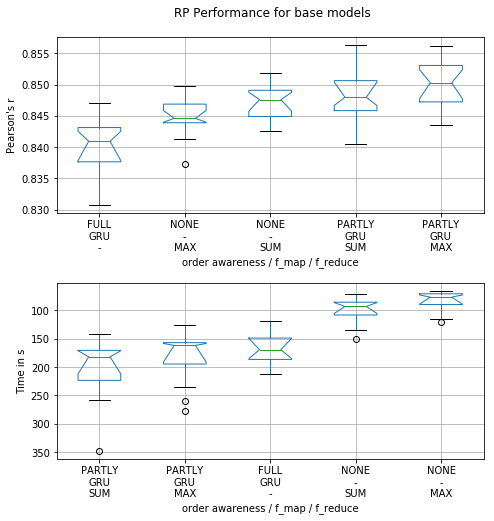

In [20]:
images = {}
bootstrap = 10000
#figsize = (4.5, 3)
figsize = (7, 7)
#figsize = (10, 10)
current_metrics = [metric_main, 'time_s']
#current_metric = metric_main

#print('columns: %s' % df_filtered.columns.values)
current_filter = [True] * len(df_filtered)


# use (only) RECNN_FULLTREE if available -> changed to RECNN and RECNN changed to RECNN_LCA
#if 'RECNN_FULLTREE' in set(df_filtered['dir_clean']):
#    current_filter = current_filter & (~df_filtered['dir_clean'].isin(['RECNN']))
    
#current_filter = current_filter & (df_filtered['dir_clean'].isin(['RNN', 'BOW', 'RECNN_FULLTREE']))
#current_filter = current_filter & (df_filtered['red'].isin(['SUM', 'MAX', '-']))
#current_filter = current_filter & (df_filtered['red'].isin(['MAX','-']))
#current_filter = current_filter & (df_filtered['red'].isin(['SUM','-']))


if TEST_BASE_MODELS:
    current_filter = current_filter & (df_filtered['feat'] == '-')
    if 'l' in df_filtered:
        current_filter = current_filter & (df_filtered['l'] == 'DIRECT')
    if 'd' in df_filtered:
        current_filter = current_filter & (df_filtered['d'] == 'F')
    _filters =  [{'red': ['MAX','SUM','-']}]#, ({'red': ['SUM','-']},{})]
    #_filters =  [{'red': ['MAX','-']}, {'red': ['SUM','-']}]#, ({'red': ['SUM','-']},{})]
    fig, axes = plt.subplots(len(current_metrics), len(_filters), figsize=figsize)
    fig.suptitle('%s Performance for base models' % format_description(task, 'task'), y=1.03, x=0.55)#, y=1)
    #fig.suptitle(format_description(metric_main, 'metric'), y=1)
    for i, m in enumerate(current_metrics):
        ax_i = axes[i] if len(current_metrics) > 1 else axes
        for j, (df, f_in, f_out) in enumerate(filter_iter(df=df_filtered[current_filter], filters=_filters)):
            ax = ax_i[j] if len(_filters) > 1 else ax_i
            #current_params = selected_params
            current_params = ['str', 'map', 'red']
            #current_params = ['m']

            boxplot_sorted(df=df, by=current_params, column=m, reverse=m in metrics_inverted, figsize=figsize, bootstrap=bootstrap, notch=True, ax=ax)#, showcaps=False)
            if j == 0:
                ax.set_ylabel(format_description(m, 'metric'))
            if m in metrics_inverted:
                ax.invert_yaxis()
            format_xticks(ax, label_part_types=('structure_to_order_awareness', 'pass', 'pass'))
            ax.set_xlabel(format_description(current_params, 'parameter').replace(', ', ' / ').replace('structure', 'order awareness'))
            if i == 0 and len(_filters) > 1:
                ax.set_title(f_in)
    plt.tight_layout(pad=1.2)
    #plt.xticks(range(1, len(xtick_labels) + 1), xtick_labels)
    #plt.suptitle('asd')

    images['base_models_%s' % task.replace('/', '_')] = fig

In [21]:
#image_path = '/mnt/DATA/RESEARCH/DT/5c44bafe1f88926e9a55da87/images/temp'
print_images(images=images, path=image_path)

# Significant Changes

In [22]:
if hasattr(temp_mean.index, 'levels'):
    exclude_cols =  ['mt', 'b', 'kp']
    if TEST_BASE_MODELS:
        exclude_cols.append('dir_clean')
    parameters_interest = [l.name for l in temp_mean.index.levels if l.name not in exclude_cols]
else:
    parameters_interest = [temp_mean.index.name]
    
if TEST_RED:
    parameters_interest = [p for p in parameters_interest if p != 'm']
#print('parameters of interest: %s' % parameters_interest)

def get_stats(m, groups, group_a_key, group_b_key, group_key_full):
    values_a = groups.get_group(group_a_key)[m].dropna().values
    values_b = groups.get_group(group_b_key)[m].dropna().values
    if len(values_a) == 0 or len(values_b) == 0:
        return None
    values_a_mean = np.mean(values_a)
    values_b_mean = np.mean(values_b)
    #t_test_results['%s|%s|(%s -> %s)|%s' % (m, p, group_a, group_b, '/'.join(group_key))] = st.ttest_ind(values_a,values_b) + (values_a_mean, values_b_mean, len(values_a), len(values_b))
    #res_key = '%s|%s|(%s -> %s)|%s' % (m, p, group_a_key, group_b_key, '|'.join(group_key_full))
    #t_test_results[res_key] = st.ttest_ind(values_a,values_b) + (values_a_mean, values_b_mean, len(values_a), len(values_b))
    return st.ttest_ind(values_a,values_b) + (values_a_mean, values_b_mean, len(values_a), len(values_b))

def get_stats_cross(groups, group_key_full):
    res = {}
    group_keys = list(groups.groups)
    #print('group_key_full: %s' % group_key_full)
    #print('group_keys: %s' % group_keys)
    if len(group_keys) > 1:
        for j, group_a in enumerate(group_keys):
            for group_b in group_keys[j + 1:]:
                for m in metrics:   
                    stats = get_stats(m=m, groups=groups, group_a_key=group_a, group_b_key=group_b, group_key_full=group_key_full)
                    if stats is not None:
                        res_key = '%s|%s|(%s -> %s)|%s' % (m, p, group_a, group_b, '|'.join(group_key_full))
                        res[res_key] = stats
    return res

#df_dropped = df_dropped[df_dropped['l'] == 'DIRECT']
df_dropped_selected = df_dropped
#df_dropped_selected = df_dropped_selected[df_dropped_selected['l'] == 'EDGES']
#df_dropped_selected = df_dropped_selected[~df_dropped_selected['feat'].str.contains('CS')]
#df_dropped_selected = df_dropped_selected[df_dropped_selected['task'].str.contains('RELATEDNESS/SICK')]

print('check changes for parameters of interest: %s' % parameters_interest)
print('metrics: %s' % metrics)
t_test_results = {}
if len(parameters_interest) > 1:
    for i, p in enumerate(parameters_interest):
        #print(p)
        other_params = [_p for _p in parameters_interest if _p != p]
        #print('p=%s: %s' % (p, other_params))
        #print('p: %s\tother: %s' % (p, other_params))
        grouped = df_dropped_selected.groupby(by=other_params)
        grouped_keys = list(grouped.groups)
        param_values = {}
        values = {}
        for group_key in grouped_keys:
            #print('group_key: %s' % group_key)
            if isinstance(group_key, tuple):
                group_key_full = list(group_key)
            else:
                group_key_full = [group_key]
            group_key_full.insert(i, '@')
            #print(group_key_full, group_key)
            
            #print(group_key_full)
            sub_groups = grouped.get_group(group_key).groupby(p)
            current_stats = get_stats_cross(groups=sub_groups, group_key_full=group_key_full)
            t_test_results.update(current_stats)
else:
    p = parameters_interest[0]
    group_key_full = ['@']
    groups = df_dropped_selected.groupby(p)
    current_stats = get_stats_cross(groups=groups, group_key_full=group_key_full)
    t_test_results.update(current_stats)
    
                    
#print(t_test_results)
    
#reformat_ttest_dict(t_test_results, metric=metric_main, index_names=('metric', 'p', 'change','fix'), index_split='|', sort_by=['p','change'], dont_show_all=True) 
#reformat_ttest_dict(t_test_results, metric=metric_main, index_names=('metric', 'p', 'change') + tuple(parameters_interest), index_split='|', sort_by=['p', 'change'], sort_reverse=False, dont_show_all=True) #sort_by=['p','change']

check changes for parameters of interest: ['m']
metrics: ['test_pearson_r', 'test_mse', 'abs_error', 'time_s', 'steps_train', 'time_step_s']


In [23]:
# METRIC_MAIN

# further filtering (just for display)
index_contains=None
#index_contains='CS'
#index_contains={'task': 'SENTIMENT/IMDB', 'l': 'DIRECT'}
#index_contains={'l': 'DIRECT', 'm': 'TREE:MAX', 'change': 'PLndex_contains={'l': 'DIRECT', 'm': 'TREE:MAX', 'change': 'PL#PL
#index_contains={'l': 'DIRECT', 'change': 'PL'}
reformat_ttest_dict(t_test_results, metric=metric_main, index_names=('metric', 'p', 'change') + tuple(parameters_interest), index_split='|', sort_by=['p', 'change', 'dif_%'], index_contains=index_contains, sort_reverse=False, dont_show_all=True) #sort_by=['p','change']



('metric', 'p', 'change', 'm')

significant changes:
increase of test_pearson_r:



NOT significant changes:
increase of test_pearson_r:


In [24]:
# TIME
reformat_ttest_dict(t_test_results, metric='time_s', index_names=('metric', 'p', 'change') + tuple(parameters_interest), index_split='|', sort_by=['p', 'change'], sort_reverse=False, index_contains=index_contains, dont_show_all=True) #sort_by=['p','change']


('metric', 'p', 'change', 'm')

significant changes:
increase of time_s:



NOT significant changes:
increase of time_s:


In [25]:
# STEPS
reformat_ttest_dict(t_test_results, metric='steps_train', index_names=('metric', 'p', 'change') + tuple(parameters_interest), index_split='|', sort_by=['p', 'change'], sort_reverse=False, index_contains=index_contains, dont_show_all=True) #sort_by=['p','change']


('metric', 'p', 'change', 'm')

significant changes:
increase of steps_train:



NOT significant changes:
increase of steps_train:


In [26]:
# TIME_PER_STEP
reformat_ttest_dict(t_test_results, metric='time_step_s', index_names=('metric', 'p', 'change') + tuple(parameters_interest), index_split='|', sort_by=['p', 'change'], sort_reverse=False, index_contains=index_contains, dont_show_all=True) #sort_by=['p','change']


('metric', 'p', 'change', 'm')

significant changes:
increase of time_step_s:



NOT significant changes:
increase of time_step_s:


,,,statistic,pvalue,mean_a,mean_b,nbr_a,nbr_b,dif,dif_%,a.05,a.01,a.001
p,change,m,,,,,,,,,,,
m,(TREE:MAX:GRU -> TREE:SUM:GRU),@,-1.8761,0.0667,0.2635,0.2397,25,25,-0.0238,-0.0991,False,False,False


In [27]:
def dir_exist_on_server(dir_path):
    _true = 'True'
    _false = 'False'
    #cmd = 'if [ -d "%s" ]; then echo True else echo False fi' % path_backup
    cmd = '[[ -d "%s" ]] && echo "%s" || echo "%s"' % (dir_path, _true, _false)
    #print('cmd: %s' % cmd)
    res = !ssh -q {server_adress} {cmd}
    assert res[0] in [_true, _false], 'unknown result: %s' % str(res)
    return res[0] == _true

def copy_run_dir(run_path):
    path_copy = run_path + '.cp'
    print(path_copy)
    if not dir_exist_on_server(path_copy):
        #print('\tcopy to dir: %s' % path_copy)
        cmd = 'cp -r "%s" "%s"' % (run_path, path_copy)
        !ssh -q {server_adress} {cmd}
        return True
    else:
        #print('\tdir already exists: %s' % path_copy)
        print('\tdir already exists')
        return False
    
#run_dir = 'RELATEDNESS/SICK/DIRECT/RECNN2/aEDG_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx4-5_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBMC2_teHTUREDUCESUMMAPGRU_ccF_tfidfF_vvrF_vvzF/0'
#run_path = os.path.join(path_server, run_dir)
#copy_run_dir(run_path)


# Best Runs

In [28]:
if task != 'ALL' and CHECK_BEST_RUNS:
    if TEST_BASE_MODELS:
        fn_best = os.path.join(path, 'BEST_BASE', task.replace('/', '-'))
        if not os.path.exists(os.path.join(path, 'BEST_BASE')):
            os.makedirs(os.path.join(path, 'BEST_BASE'))
    else:
        fn_best = os.path.join(path, 'BEST', task.replace('/', '-'))
        if not os.path.exists(os.path.join(path, 'BEST')):
            os.makedirs(os.path.join(path, 'BEST'))
    if not os.path.exists(fn_best):
        # run_desc_new
        best_runs = df_filtered.sort_values(metric_main, ascending=False).drop_duplicates(['run_desc_new', 'dir_clean'])
        best_runs['path_local'] = best_runs.apply(lambda row: os.path.join(*row['path'].split('/')[:-1]+ [row['dir_clean'], row[COLUMN_RUN_DESC_NEW]]), axis=1)
        best_runs['path_server'] = best_runs.apply(lambda row: os.path.join(row['path'], row[COLUMN_RUN_DESC]), axis=1)
        print('dump best_runs to: %s' % fn_best)
        best_runs.to_pickle(fn_best)
    else:
        print('load best_runs from file: %s' % fn_best)
        best_runs = pd.read_pickle(fn_best)
    
    
    if LOAD_DATA:
        run_paths_server = []
        files_to_copy = ['train-debug.log', 'values_gold.np', 'values_gold_strings.txt', 'values_predicted_strings.txt', 'values_predicted.np', 'tree_indices.test.npy', 'tree_indices.loaded.test.npy']
        print('download files from server: %s' % files_to_copy)
        assert len(best_runs) == len(set(best_runs['path_local'])), 'local_paths are not unique'
        for index, row in best_runs.iterrows():
            #print(row)
            full_path_server = os.path.join(path_server, row['path_server'])
            if not dir_exist_on_server(full_path_server +'.cp'):
                print('WARNING: no backup (.cp) dir found for %s. continue!' % row['path_server'])
                if copy_run_dir(full_path_server):
                    run_paths_server.append(row['path_server'])
            else:
                full_path_local = os.path.join(path, row['path_local'])
                if os.path.exists(full_path_local):
                    print('WARNING: remove %s' % full_path_local)
                    shutil.rmtree(full_path_local)
                os.makedirs(full_path_local)
                print('copy from: %s' % full_path_server)
                for fn in files_to_copy:
                    fn_full = os.path.join(full_path_server, fn)
                    !scp {server_adress}:{fn_full} {full_path_local}/  
        print('DONE\n')
            #print('%s -> %s' % (full_path_server, full_path_local))
            #print(full_path_server)
            #print('-> %s' % full_path_local)
        if len(run_paths_server):
            print('NEED to CONTINUE:')
            print(','.join(run_paths_server))
    

load best_runs from file: /home/arne/recursive-embedding/DT/experiments/results/BEST_BASE/RELATEDNESS-SICK


In [29]:
if task != 'ALL' and CHECK_BEST_RUNS:
    print('nbr of distinct settings: %i' % len(best_runs)) 
    # add parameter counts
    par_data = []
    for index, row in best_runs.iterrows(): 
        full_path_local_log = os.path.join(path, row['path_local'], 'train-debug.log')
        if not os.path.exists(full_path_local_log):
            print('WARNING: %s not found' % full_path_local_log)
        else:
            par_data.append(get_parameter_data_from_log(full_path_local_log))


    # note: index has to taken from best_runs to merge correctly
    #best_runs['model_par_data'] = pd.Series(par_data, index=best_runs.index)
    best_runs_param_data = pd.DataFrame(par_data, index=best_runs.index)
    best_runs = pd.concat([best_runs, best_runs_param_data], axis=1)
        
    
    #full_path_server = best_runs.apply(lambda row: os.path.join(path_server, row['path'], row[COLUMN_RUN_DESC]))
    #full_path_local = best_runs.apply(lambda row: os.path.join(path_server, row['path'], row[COLUMN_RUN_DESC]))
    #display_colored(best_runs[(best_runs['map'] == 'GRU') & (best_runs['feat'] == '-')], columns=['params_remaining_train_nbr', 'params_treeembedder_train_nbr']) # [:5]
    #display_colored(best_runs, columns=['params_remaining_train_nbr', 'params_treeembedder_train_nbr'])
    #best_runs.style.apply(colormap_columns, columns=columns, columns_inverted=columns_inverted, axis=0)

    # created df to display with less columns
    best_runs_display = best_runs[[c for c in best_runs.columns.values if c not in ['run_description', 'run_desc_new']]]#, 'path_local', 'path_server']]]
    display(best_runs_display)
    #best_runs_display.style.apply(colormap_columns, cm=sns.light_palette("green", as_cmap=True), columns=['params_remaining_train_nbr', 'params_treeembedder_train_nbr'], columns_inverted=['params_remaining_train_nbr', 'params_treeembedder_train_nbr'], axis=0)

nbr of distinct settings: 5


,ct,feat,map,red,test_pearson_r,test_mse,abs_error,time_s,steps_train,time_step_s,dir_clean,dir,path,dev_best_pearson_r,dev_best_mse,a,avf,b,bs,cc,clp,cm,cntxt,dfidx,dpth,dt,kp,kpb,kpn,l,lc,leaffc,lr,mt,n,nfv,ns,rootfc,run,sl,st,tfidf,vvr,vvz,str,path_local,path_server,params_remaining_fix_details,params_remaining_fix_nbr,params_remaining_train_details,params_remaining_train_nbr,params_treeembedder_train_details,params_treeembedder_train_nbr
190,TREE,-,GRU,SUM,0.856304,0.023019,0.113541,199.208167,864,0.230565,RECNN,RECNN2,RELATEDNESS/SICK/DIRECT/RECNN2,0.845950,0.025170,EDG,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,"4,5",20,F,0.9,1.0,1.0,DIRECT,-1,0,0.001,SIMTUPLE,10000,F,20,300,0,50,150,F,F,F,RECNN,RELATEDNESS/SICK/DIRECT/RECNN/aEDG_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:SUM-GRU_mtSIMTUPLE_n10000_nfvF_ns20_rootfc300_sl50_sm_st150_tfidfF_tk_vvrF_vvzF,RELATEDNESS/SICK/DIRECT/RECNN2/aEDG_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx4-5_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBMC2_teHTUREDUCESUMMAPGRU_ccF_tfidfF_vvrF_vvzF/0,"{u'embeddings_fix': [2403, 300], u'beta2_power': [], u'beta1_power': [], u'global_step': []}",720900,"{u'embeddings/Adam': [259, 300]}",77700,"{u'TreeEmbedding/HTU_mapGRU_reduceSUM_/gru_cell/candidate/bias/Adam': [150], u'TreeEmbedding/FC_root/0/weights/Adam': [150, 300], u'TreeEmbedding/HTU_mapGRU_reduceSUM_/gru_cell/gates/kernel/Adam': [500, 300], u'TreeEmbedding/HTU_mapGRU_reduceSUM_/gru_cell/candidate/kernel/Adam': [500, 150], u'TreeEmbedding/FC_root/0/biases/Adam': [300], u'TreeEmbedding/HTU_mapGRU_reduceSUM_/gru_cell/gates/bias/Adam': [300]}",270750
22,TREE,-,GRU,MAX,0.856166,0.022150,0.111464,161.962945,648,0.249943,RECNN,RECNN,RELATEDNESS/SICK/DIRECT/RECNN,0.858523,0.021808,EDG,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,"0,1",20,F,0.9,1.0,1.0,DIRECT,-1,0,0.001,SIMTUPLE,10000,F,20,300,1,50,150,F,F,F,RECNN,RELATEDNESS/SICK/DIRECT/RECNN/aEDG_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU_mtSIMTUPLE_n10000_nfvF_ns20_rootfc300_sl50_sm_st150_tfidfF_tk_vvrF_vvzF,RELATEDNESS/SICK/DIRECT/RECNN/aEDG_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBMC2_teHTUREDUCEMAXMAPGRU_ccF_tfidfF_vvrF_vvzF/1,"{u'embeddings_fix': [2403, 300], u'beta2_power': [], u'beta1_power': [], u'global_step': []}",720900,"{u'embeddings/Adam': [259, 300]}",77700,"{u'TreeEmbedding/HTU_mapGRU_reduceMAX_/gru_cell/candidate/bias/Adam': [150], u'TreeEmbedding/HTU_mapGRU_reduceMAX_/gru_cell/gates/kernel/Adam': [500, 300], u'TreeEmbedding/HTU_mapGRU_reduceMAX_/gru_cell/candidate/kernel/Adam': [500, 150], u'TreeEmbedding/FC_root/0/weights/Adam': [150, 300], u'TreeEmbedding/FC_root/0/biases/Adam': [300], u'TreeEmbedding/HTU_mapGRU_reduceMAX_/gru_cell/gates/bias/Adam': [300]}",270750
390,FLAT,-,-,SUM,0.851864,0.023341,0.114100,94.379188,1332,0.070855,BOW,RNN,RELATEDNESS/SICK/DIRECT/RNN,0.844240,0.025287,EDG,F,,100,F,5.0,AGGREGATE,0,"4,5",20,F,0.9,1.0,1.0,DIRECT,-1,150,0.001,SIMTUPLE,10000,F,20,300,0,50,0,F,F,F,BOW,RELATEDNESS/SICK/DIRECT/BOW/aEDG_avfF_b_bs100_ccF_clp5.0_cmAGGREGATE_cntxt0_dF_dpth20_dtF_fc_kp0.9_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc150_lr0.001_mFLAT:SUM_mtSIMTUPLE_n10000_nfvF_ns20_rootfc300_sl50_sm_st0_tfidfF_tk_vvrF_vvzF,RELATEDNESS/SICK/DIRECT/RNN/aEDG_avfF_bs100_dF_b_clp5.0_cmAGGREGATE_cntxt0_dfidx4-5_dtF_fc_kp0.9_kpb1.0_kpn1.0_leaffc150_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st0_tk_dataCORENLPNONERRECEMBMC2_teFLATSUM_ccF_tfidfF_vvrF_vvzF/0,"{u'embeddings_fix': [2403, 300], u'beta2_power': [], u'beta1_power': [], u'global_step': []}",720900,"{u'embeddings/Adam': [259, 300]}",77700,"{u'TreeEmbedding/FLAT_reduceSU

# CHANGE OVERLAP HERE

In [30]:
def get_scores_simplified(scores_gold, scores_predicted, sort_by=None, discretize=True):
    assert scores_gold.shape == scores_predicted.shape, 'scores_gold.shape [%s] does not match scores_predicted.shape [%s]' % (scores_gold.shape, scores_predicted.shape)
    
    print('shape: %s' % str(scores_gold.shape))
    if len(scores_gold.shape) == 1:
        res_gold, res_predicted = scores_gold, scores_predicted
    else:
        assert len(scores_gold.shape) == 2, 'expected two dimensional shape, but found: %s' % scores_gold.shape
        if scores_gold.shape[-1] == 1:
            res_gold, res_predicted = scores_gold.flatten(), scores_predicted.flatten()
        else:
            max_indices = scores_gold.argmax(axis=1)
            res_gold, res_predicted = scores_gold[np.arange(len(scores_gold)), max_indices], scores_predicted[np.arange(len(scores_gold)), max_indices]
    if sort_by is not None:
        if len(sort_by) == len(res_gold) * 2:
            sort_by = sort_by.reshape((-1, 2))[:,0]
        assert len(sort_by) == len(res_gold), 'lenght of sort_by array [%i] does not match length of results [%i]' % (len(sort_by), len(res_gold))
        indices_sorted = np.argsort(sort_by)
        res_gold, res_predicted = res_gold[indices_sorted], res_predicted[indices_sorted]
    
    if discretize:
        if task in ['ENTAILMENT/SICK', 'SENTIMENT/IMDB']:
            res_predicted = (res_predicted + 0.5).astype(int).astype(float)
        elif task == 'RE/SEMEVAL2010T8':
            res_predicted = (res_predicted + 0.67).astype(int).astype(float)
    return res_gold, res_predicted
        


#temp_path = '/mnt/DATA/ML/experiments/FINAL/RELATEDNESS/SICK/DIRECT/BOW/aEDG_avfF_b_bs100_ccF_clp5.0_cmAGGREGATE_cntxt0_dF_dpth20_dtF_fc_kp0.9_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mFLAT:GRU_mtSIMTUPLE_n10000_nfvF_ns20_rootfc300_sl50_sm_st150_tfidfF_tk_vvrF_vvzF'
#temp_path_local = 'RELATEDNESS/SICK/DIRECT/RECNN/aEDG_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:SUM-GRU_mtSIMTUPLE_n10000_nfvF_ns20_rootfc300_sl50_sm_st150_tfidfF_tk_vvrF_vvzF'

def symbol_list_to_tuples(symbol_list, return_types=(u'conll:WORD', u'conll:EDGE')): #return_types=(u'conll:EDGE')): #
    i = 0
    res = []
    current = []
    for s in symbol_list:
        if s == u'UNKNOWN':
            s = u'conll:WORD=' + s
        try:
            _t, _s = s.split('=', 1)
        except Exception as e:
            print(s)
            raise e
        if _t in return_types: #[u'conll:WORD', u'conll:EDGE']:
            current.append(_s)
        elif _t == u'conll:UPOS':
            # DEBUG OFF
            #assert len(current) == len(return_types), 'wrong number of entries [%i], expected 2: %s' % (len(current), str(current))
            if len(return_types) == 1:
                res.append(current[0])
            else:
                res.append(tuple(current))
            current = []
        #else:
        #    print('WARNING: unknown type: %s (s: %s)' % (_t, _s))
    return res


def get_stats_for_data(data_dir, take_two=False):
    _data_path = os.path.join(path_data, data_dir)
    tokens_path = os.path.join(_data_path, 'STATS', 'tokens.0.json')
    if os.path.exists(tokens_path):
        _tokens_lists = json.load(open(tokens_path))
        _tokens = np.array([symbol_list_to_tuples(tokens) for tokens in _tokens_lists])
        print(len(_tokens))
    else:
        _tokens = None
        print('WARNING: could not find preprocessed tokens file (%s)' % tokens_path)
    _lengths = np.load(os.path.join(_data_path, 'STATS', 'length.0.np'))
    print(len(_lengths))
    _depths = np.load(os.path.join(_data_path, 'STATS', 'depth.0.np'))
    print(len(_depths))
    
    if _tokens is not None:
        assert len(_tokens) == len(_depths) == len(_lengths), 'number of tokens [%i] / depths [%i] / lengths [%i] do not match' % (len(_tokens), len(_depths), len(_tokens))
    else:
        assert len(_depths) == len(_lengths), 'number of depths [%i] / lengths [%i] do not match' % (en(_depths), len(_lengths))
    if not take_two:
        return {'tokens': _tokens, 'length': _lengths, 'depth': _depths}
    else:
        res = {'tokens_a': _tokens[0::2], 'length_a': _lengths[0::2], 'depth_a': _depths[0::2], 
                'tokens_b': _tokens[1::2], 'length_b': _lengths[1::2], 'depth_b': _depths[1::2], 
                'length': np.maximum(_lengths[0::2], _lengths[1::2]), 'depth': np.maximum(_depths[0::2], _depths[1::2]),
                'length_difabs': np.absolute(_lengths[0::2] - _lengths[1::2]), 'depth_difabs': np.absolute(_depths[0::2] - _depths[1::2])
               }
        return res
    #temp_path = '/mnt/DATA/ML/experiments/FINAL/SENTIMENT/IMDB/DIRECT/RECNN/aEDG_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth50_dtF_ec_fc400_kp0.9_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU_mtCLASS_n10000_nfvF_ns20_rootfc_sl500_sm_st350_tfidfF_tkSTM_vvrF_vvzF'
    #temp_path = '/mnt/DATA/ML/experiments/FINAL/RE/SEMEVAL2010T8/DIRECT/BOW/aEDG-ARGS_avfF_b_bs100_ccF_clp5.0_cmAGGREGATE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.9_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc250_lr0.001_mFLAT:MAX_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st0_tfidfF_tkRELS_vvrF_vvzF'

def get_scores_for_run(run_row, discretize=True):
    _path_local = run_row['path_local']
    print('get scores from: %s' % _path_local)
    #temp_path = '/mnt/DATA/ML/experiments/FINAL/SENTIMENT/IMDB/DIRECT/RECNN/aEDG_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth50_dtF_ec_fc400_kp0.9_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU_mtCLASS_n10000_nfvF_ns20_rootfc_sl500_sm_st350_tfidfF_tkSTM_vvrF_vvzF'
    #temp_path = '/mnt/DATA/ML/experiments/FINAL/RE/SEMEVAL2010T8/DIRECT/BOW/aEDG-ARGS_avfF_b_bs100_ccF_clp5.0_cmAGGREGATE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.9_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc250_lr0.001_mFLAT:MAX_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st0_tfidfF_tkRELS_vvrF_vvzF'
    _full_path_local = os.path.join(path, _path_local)
    #temp_path_data = os.path.join(path_data, task_setting['data'])

    _scores_gold_loaded = np.load(os.path.join(_full_path_local, 'values_gold.np'))
    #print(_scores_gold_loaded[:10])
    #print(temp_scores_gold_loaded[:10] * 4.0 + 1)
    _scores_predicted_loaded = np.load(os.path.join(_full_path_local, 'values_predicted.np'))
    #temp_indices_test = np.load(os.path.join(temp_path, 'tree_indices.test.npy'))
    #print(temp_indices_test[:100])
    #print(np.array_equal(temp_indices_test[:100], np.sort(temp_indices_test)[:100]))
    _scores_gold, _scores_predicted = get_scores_simplified(_scores_gold_loaded, _scores_predicted_loaded, discretize=discretize)#, sort_by=temp_indices_test)
    #print(len(_scores_gold))
    #print(len(_scores_predicted))
    #print(temp_scores_gold[:10] * 4.0 + 1)
    #print(np.around(temp_scores_predicted[:10] * 4.0 + 1,decimals=1))
    #_errors = np.abs(_scores_gold - _scores_predicted)
    return _scores_gold, _scores_predicted
#temp_indices_test[:10]
#temp_errors

def get_scores_df(run_row, index_suffix=None, discretize=True):
    if index_suffix is None:
        index_suffix = ''
    else:
        index_suffix = '_' + index_suffix
    _scores_gold, _scores_predicted = get_scores_for_run(run_row, discretize=discretize)
    _errors = np.abs(_scores_gold - _scores_predicted)
    df_temp = pd.DataFrame.from_dict({'scores_gold'+index_suffix: _scores_gold, 'scores_predicted'+index_suffix:_scores_predicted, 'errors'+index_suffix: _errors})
    _m = ':'.join([run_row['ct'], run_row['red'] if 'red' in run_row else 'X', run_row['map']])
    if 'feat' in run_row:
        _m = _m + ':' + run_row['feat']
    #df_temp.set_index('m', append=True, inplace=True)
    #print(df_temp.index)
    new_index = pd.MultiIndex.from_product([df_temp.columns.values, [_m]], names=['scores', 'm'])
    #print(new_index)
    #return pd.DataFrame(df_temp, columns=new_index)
    return df_temp.T.set_index(new_index).T, _m
    #return df_temp

In [31]:
#data_stats_all = {}
df_data_stats_all = {}
for l in ['EDGES', 'DIRECT']:
    #task_setting['data'][SELECT_LINKING]
    data_stats = get_stats_for_data(task_setting['data'][l], take_two=(task in ['RELATEDNESS/SICK', 'ENTAILMENT/SICK']))
    df_data_stats_all[l] = pd.DataFrame.from_dict(data_stats)
#new_index = pd.MultiIndex.from_product([['DATA'],df_data_stats.columns.values], names=['m', 'scores'])

9854
9854
9854
9854
9854
9854


In [32]:
best_runs.groupby([col for col in ['ct', 'feat', 'map', 'red', 'l','task'] if col in best_runs]).count()

test_pearson_r  test_mse  abs_error  time_s  \
ct   feat map red l                                                     
FLAT -    -   MAX DIRECT  1               1         1          1        
              SUM DIRECT  1               1         1          1        
          GRU -   DIRECT  1               1         1          1        
TREE -    GRU MAX DIRECT  1               1         1          1        
              SUM DIRECT  1               1         1          1        

                          steps_train  time_step_s  dir_clean  dir  path  \
ct   feat map red l                                                        
FLAT -    -   MAX DIRECT  1            1            1          1    1      
              SUM DIRECT  1            1            1          1    1      
          GRU -   DIRECT  1            1            1          1    1      
TREE -    GRU MAX DIRECT  1            1            1          1    1      
              SUM DIRECT  1            1            1          1    1      

                          run_description  dev_best_pearson_r  dev_best_mse  \
ct   feat map red l                                                           
FLAT -    -   MAX DIRECT  1                1                   1              
              SUM DIRECT  1                1                   1              
          GRU -   DIRECT  1                1                   1              
TREE -    GRU MAX DIRECT  1                1                   1              
              SUM DIRECT  1                1                   1              

                          a  avf  b  bs  cc  clp  cm  cntxt  dfidx  dpth  dt  \
ct   feat map red l                                                            
FLAT -    -   MAX DIRECT  1  1    1  1   1   1    1   1      1      1     1    
              SUM DIRECT  1  1    1  1   1   1    1   1      1      1     1    
          GRU -   DIRECT  1  1    1  1   1   1    1   1      1      1     1    
TREE -    GRU MAX DIRECT  1  1    1  1   1   1    1   1      1      1     1    
              SUM DIRECT  1  1    1  1   1   1    1   1      1      1     1    

                          kp  kpb  kpn  lc  leaffc  lr  mt  n  nfv  ns  \
ct   feat map red l                                                      
FLAT -    -   MAX DIRECT  1   1    1    1   1       1   1   1  1    1    
              SUM DIRECT  1   1    1    1   1       1   1   1  1    1    
          GRU -   DIRECT  1   1    1    1   1       1   1   1  1    1    
TREE -    GRU MAX DIRECT  1   1    1    1   1       1   1   1  1    1    
              SUM DIRECT  1   1    1    1   1       1   1   1  1    1    

                          rootfc  run  run_desc_new  sl  st  tfidf  vvr  vvz  \
ct   feat map red l                                                            
FLAT -    -   MAX DIRECT  1       1    1             1   1   1      1    1     
              SUM DIRECT  1       1    1             1   1   1      1    1     
          GRU -   DIRECT  1       1    1             1   1   1      1    1     
TREE -    GRU MAX DIRECT  1       1    1             1   1   1      1    1     
              SUM DIRECT  1       1    1             1   1   1      1    1     

                          str  path_local  path_server  \
ct   feat map red l                                      
FLAT -    -   MAX DIRECT  1    1           1             
              SUM DIRECT  1    1           1             
          GRU -   DIRECT  1    1           1             
TREE -    GRU MAX DIRECT  1    1           1             
              SUM DIRECT  1    1           1             

                          params_remaining_fix_details  \
ct   feat map red l                                      
FLAT -    -   MAX DIRECT  1                              
              SUM DIRECT  1                              
          GRU -   DIRECT  1                              
TREE -    GRU MAX DIRECT  1                              
              SUM DIRECT  1    

In [33]:
def compare_best_recnn_and_rnn(runs, filter_a, filter_b, df_data, discretize=True):
    _dfs = []
    _ms = []
    _cols = []
    _filters = [filter_a, filter_b]
    for _filter in _filters:
        runs_filtered = runs[_filter]
        assert len(runs_filtered) == 1, 'nbr of recnns should by 1, but is %i' % len(runs_filtered)
        #runs_b = runs[filter_b]
        #assert len(rnns) == 1, 'nbr of rnns should by 1, but is %i' % len(rnns)
        run_selected = runs_filtered.iloc[0]
        
        #run_b = runs_b.iloc[0]
        
        df_scores, _m = get_scores_df(run_selected, discretize=discretize)
        print('%s: %f (%s)' % (_m, run_selected[metric_main], metric_main))
        #df_scores_rnn = get_scores_df(run_b)
        _dfs.append(df_scores)
        _ms.append(_m)
        #display(df_scores[:5])
        _cols.extend(df_scores.columns.values)
    #_cols = np.array(_cols)#.reshape((-1,len(_filters)))
    
    
    #print(_cols)
    df_scores_data = pd.concat(_dfs + [df_data], axis=1)
    #print(_m)
    #display(df_scores_data[:5])
    
    df_scores_data[('errors', 'DIF')] = df_scores_data[('errors', _ms[1])] - df_scores_data[('errors', _ms[0])]
    _cols.append(('errors', 'DIF'))
    _cols = [('scores_gold', _ms[0])] + [(a,b) for a,b in sorted(_cols) if a != 'scores_gold']
    
    _cols.extend(list(df_data))
    df_scores_data = df_scores_data[_cols].rename(columns={('scores_gold', _ms[0]): 'scores_gold'})
    
    return df_scores_data.rename(columns={_col: '%s/%s' % (_col[0], _col[1]) for _col in list(df_scores_data) if isinstance(_col, tuple)}), _ms

print('best_red: %s' % best_red)
#print(set(best_runs['path_local']))
#filter_competitor_model = (best_runs['map'] != '-') & (best_runs['red'] == '-')
print('best_competitor: %s' % str(best_competitor))
#if task == 'RELATEDNESS/SICK':
#    # FLAT:SUM
#    filter_competitor_model = (best_runs['map'] == '-') & (best_runs['red'] == 'SUM')
#    #filter_competitor_model = (best_runs['map'] == 'GRU') & (best_runs['red'] == '-')
#else:
#    # FLAT:GRU
#    filter_competitor_model = (best_runs['map'] != '-') & (best_runs['red'] == '-')
l = 'DIRECT'
filter_model = (best_runs['map'] == 'GRU') & (best_runs['red'] == best_red)
#filter_competitor_model = (best_runs['map'] == best_competitor['map']) & (best_runs['red'] == best_competitor['red'])
#filter_model = (best_runs['feat'] == 'BD-IS-LCA') & (best_runs['l'] == 'EDGES')
print('nbr model rows (should be 1): %i' % len(best_runs[filter_model]))
#filter_model = (best_runs['feat'] == 'LCA-PL') & (best_runs['l'] == 'DIRECT')
if best_competitor is not None:
    #filter_competitor_model = (best_runs['feat'] == 'BD-LCA-PL') & (best_runs['l'] == 'DIRECT')
    filter_competitor_model = (best_runs['map'] == best_competitor['map']) & (best_runs['red'] == best_competitor['red'])
else:
    raise NotImplementedError('define a competitor manually')
#row_competitor_mode = best_runs[filter_competitor_model]
print('nbr model competitor rows (should be 1): %i' % len(best_runs[filter_competitor_model]))
#filter_competitor_model = (best_runs['feat'] == 'LCA') & (best_runs['l'] == 'EDGES')

df_scores_data, ms = compare_best_recnn_and_rnn(best_runs, filter_a=filter_model, filter_b=filter_competitor_model, df_data=df_data_stats_all[l], discretize=False)
print('MODELS: %s' % ms)
if task in ['RELATEDNESS/SICK', 'ENTAILMENT/SICK']:
    #df_scores_data['overlap'] = df_scores_data.apply(lambda row: len(set(row['tokens_a']).update(set(row['tokens_a'])))/(len(set(row['tokens_a'])) + len(set(row['tokens_b']))), axis=1)
    df_scores_data['overlap'] = df_scores_data.apply(lambda row: len(set(row['tokens_a']) & set(row['tokens_b'])) / float(len(set(row['tokens_a']) | set(row['tokens_b']))), axis=1)
    df_scores_data['overlap_gold_dif'] = np.absolute(df_scores_data['overlap'] - df_scores_data['scores_gold'])
    df_scores_data['overlap_data'] = df_scores_data.apply(lambda row: set(row['tokens_a']) & set(row['tokens_b']), axis=1)
    #df_scores_data['has_passive'] = df_scores_data.apply(lambda row: any(['pass' in x[1] for x in row['tokens_a'] + row['tokens_b']]), axis=1)

df_scores_data['depth_length_ratio'] = df_scores_data['depth'] / df_scores_data['length']
df_scores_data['depth_length_product'] = df_scores_data['depth'] * df_scores_data['length']
df_scores_data['depth_length_sum'] = df_scores_data['depth'] + df_scores_data['length']

df_scores_data['length_cut'] = df_scores_data.apply(lambda row: min(row['length'], data_max['length']), axis=1)
df_scores_data['depth_cut'] = df_scores_data.apply(lambda row: min(row['depth'], data_max['depth']), axis=1)

#df_scores_data[:3]
df_scores_data.describe()

best_red: MAX
best_competitor: {'map': '-', 'red': 'SUM'}
nbr model rows (should be 1): 1
nbr model competitor rows (should be 1): 1
get scores from: RELATEDNESS/SICK/DIRECT/RECNN/aEDG_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc_kp0.9_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU_mtSIMTUPLE_n10000_nfvF_ns20_rootfc300_sl50_sm_st150_tfidfF_tk_vvrF_vvzF
shape: (4927,)
TREE:MAX:GRU:-: 0.856166 (test_pearson_r)
get scores from: RELATEDNESS/SICK/DIRECT/BOW/aEDG_avfF_b_bs100_ccF_clp5.0_cmAGGREGATE_cntxt0_dF_dpth20_dtF_fc_kp0.9_kpb1.0_kpn1.0_lDIRECT_lc-1_leaffc150_lr0.001_mFLAT:SUM_mtSIMTUPLE_n10000_nfvF_ns20_rootfc300_sl50_sm_st0_tfidfF_tk_vvrF_vvzF
shape: (4927,)
FLAT:SUM:-:-: 0.851864 (test_pearson_r)
MODELS: ['TREE:MAX:GRU:-', 'FLAT:SUM:-:-']


,scores_gold,errors/DIF,errors/FLAT:SUM:-:-,errors/TREE:MAX:GRU:-,scores_predicted/FLAT:SUM:-:-,scores_predicted/TREE:MAX:GRU:-,depth,depth_a,depth_b,depth_difabs,length,length_a,length_b,length_difabs,overlap,overlap_gold_dif,depth_length_ratio,depth_length_product,depth_length_sum,length_cut,depth_cut
count,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000
mean,0.632505,0.002635,0.114100,0.111464,0.701645,0.697125,6.929775,6.672620,6.644408,0.542521,11.688451,10.746093,10.579663,2.051147,0.450785,0.258255,0.641699,83.604019,18.618226,11.688451,6.929775
std,0.252217,0.080857,0.101608,0.098629,0.248221,0.247475,0.980701,0.872848,0.863032,0.787236,3.972162,3.743918,3.763849,2.374119,0.253080,0.178989,0.169916,38.841669,4.685325,3.972162,0.980701
min,0.000000,-0.376595,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000,5.000000,0.000000,5.000000,4.000000,4.000000,0.000000,0.035714,0.000000,0.280000,25.000000,10.000000,5.000000,5.000000
25%,0.500000,-0.035346,0.034447,0.033415,0.596236,0.591898,6.000000,6.000000,6.000000,0.000000,9.000000,8.000000,8.000000,1.000000,0.235294,0.116667,0.529412,54.000000,15.000000,9.000000,6.000000
50%,0.650000,0.000000,0.088144,0.086239,0.759805,0.745659,7.000000,6.000000,6.000000,0.000000,11.000000,10.000000,10.000000,1.000000,0.400000,0.232143,0.615385,77.000000,18.000000,11.000000,7.000000
75%,0.825000,0.041240,0.163523,0.161981,0.887658,0.884396,7.000000,7.000000,7.000000,1.000000,14.000000,13.000000,13.000000,3.000000,0.666667,0.370455,0.750000,104.000000,21.000000,14.000000,7.000000
max,1.000000,0.404765,0.641391,0.630157,1.000000,0.999610,15.000000,12.000000,15.000000,7.000000,31.000000,29.000000,31.000000,20.000000,1.000000,0.933333,1.200000,435.000000,44.000000,31.000000,15.000000


In [34]:
if 'overlap_gold_dif' in df_scores_data:
    print(df_scores_data.sort_values('overlap_gold_dif')[-1000:]['errors/DIF'].mean())
    print(df_scores_data.sort_values('overlap_gold_dif')[:1000]['errors/DIF'].mean())
#df_scores_data[df_scores_data['overlap_gold_dif'] >= 0.8].sort_values('scores_gold')[:20]

-0.0039389655
0.0058898423


['TREE:MAX:GRU:-', 'FLAT:SUM:-:-']
nbr of records where TREE:MAX:GRU:- much better FLAT:SUM:-:-
8
nbr of records where FLAT:SUM:-:- much better TREE:MAX:GRU:-
6
nbr of total records: 4927


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9584375610>]],
      dtype=object)

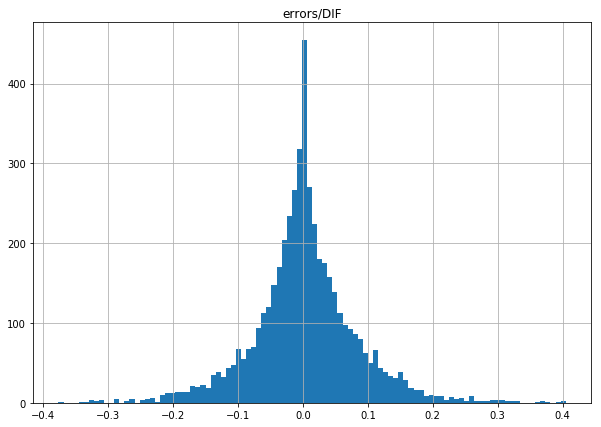

In [35]:
print(ms)
thresh = 0.5
for i in range(len(ms)):
    print('nbr of records where %s much better %s' % (ms[i], ms[::-1][i]))
    print(len(df_scores_data[(df_scores_data['errors/' + ms[i]] < thresh) & (df_scores_data['errors/' + ms[::-1][i]] > thresh)]))
    #print(len(df_scores_data_sorted[df_scores_data_sorted['errors/DIF'] > 0.25]))
print('nbr of total records: %i' % len(df_scores_data))

df_scores_data.hist(column='errors/DIF', bins=100, figsize=(10,7))

In [36]:
# best 20 RECNN
df_scores_data_sorted = df_scores_data.sort_values(by='errors/DIF')
df_scores_data_sorted[-20:]

,scores_gold,errors/DIF,errors/FLAT:SUM:-:-,errors/TREE:MAX:GRU:-,scores_predicted/FLAT:SUM:-:-,scores_predicted/TREE:MAX:GRU:-,depth,depth_a,depth_b,depth_difabs,length,length_a,length_b,length_difabs,tokens_a,tokens_b,overlap,overlap_gold_dif,overlap_data,depth_length_ratio,depth_length_product,depth_length_sum,length_cut,depth_cut
162,0.20000,0.296008,0.307021,0.011013,0.507021,0.188987,6,6,6,0,8,6,8,2,"[(Several, amod), (children, nsubj), (are, aux), (standing, ROOT), (up, advmod), (., punct)]","[(Two, nummod), (girls, nsubj), (are, aux), (sitting, ROOT), (on, case), (the, det), (ground, nmod), (., punct)]",0.166667,0.033333,"{(are, aux), (., punct)}",0.750000,48,14,8,6
530,0.47500,0.300793,0.324251,0.023458,0.799251,0.451542,8,8,7,1,12,11,12,1,"[(A, det), (person, ROOT), (who, nsubj), (is, aux), (practicing, acl:relcl), (snowboarding, xcomp), (jumps, dobj), (into, case), (the, det), (air, nmod), (., punct)]","[(A, det), (leap, nsubj), (over, case), (white, amod), (snow, nmod), (is, aux), (greatly, advmod), (appealing, ROOT), (to, case), (the, det), (snowboarders, nmod), (., punct)]",0.210526,0.264474,"{(., punct), (the, det), (is, aux), (A, det)}",0.666667,96,20,12,8
4859,0.02500,0.302162,0.327162,0.025000,0.352162,0.000000,8,8,7,1,16,16,13,3,"[(A, det), (rock, nsubjpass), (is, aux), (being, auxpass), (climbed, ROOT), (by, case), (a, det), (person, nmod), (with, case), (a, det), (rope, nmod), (,, punct), (which, nsubj), (is, cop), (pink, acl:relcl), (., punct)]","[(Two, nummod), (people, nsubj), (in, case), (a, det), (race, nmod), (are, aux), (flipping, ROOT), (the, det), (tires, dobj), (of, case), (a, det), (tractor, nmod), (., punct)]",0.080000,0.055000,"{(., punct), (a, det)}",0.500000,128,24,16,8
4538,0.23375,0.304209,0.500993,0.196784,0.734743,0.430534,6,6,6,0,12,9,12,3,"[(A, det), (shirtless, amod), (woman, nsubj), (is, aux), (jumping, ROOT), (over, compound:prt), (a, det), (log, dobj), (., punct)]","[(A, det), (guy, nsubj), (is, aux), (leaping, ROOT), (into, case), (the, det), (air, nmod), (in, case), (a, det), (wooded, amod), (area, nmod), (., punct)]",0.235294,0.001544,"{(., punct), (a, det), (is, aux), (A, det)}",0.500000,72,18,12,6
4906,0.00000,0.306543,0.306543,0.000000,0.306543,0.000000,6,6,6,0,9,8,9,1,"[(A, det), (squirrel, nsubj), (is, aux), (running, ROOT), (around, advmod), (in, case), (circles, nmod), (., punct)]","[(The, det), (man, nsubj), (is, aux), (removing, ROOT), (knives, dobj), (from, case), (a, det), (tree, nmod), (., punct)]",0.133333,0.133333,"{(is, aux), (., punct)}",0.666667,54,15,9,6
849,0.45000,0.309520,0.318081,0.008561,0.768081,0.441439,7,7,6,1,10,7,10,3,"[(Few, amod), (men, ROOT), (like, mark), (pouring, acl), (tomato, compound), (oil, dobj), (., punct)]","[(The, det), (man, nsubj), (is, aux), (pouring, ROOT), (some, det), (oil, dobj), (on, case), (the, det), (tomatoes, nmod), (., punct)]",0.133333,0.316667,"{(oil, dobj), (., punct)}",0.700000,70,17,10,7
4344,0.25000,0.310944,0.465494,0.154550,0.715494,0.404550,8,8,6,2,16,16,9,7,"[(A, det), (boy, nsubj), (is, aux), (wearing, ROOT), (all, det), (black, dobj), (and, cc), (is, aux), (sliding, conj), (down, compound:prt), (a, det), (blow, dobj), (up, case), (yellow, amod), (slide, nmod), (., punct)]","[(A, det), (girl, nsubj), (is, aux), (speeding, ROOT), (down, compound:prt), (a, det), (steep, amod), (slide, dobj), (., punct)]",0.263158,0.013158,"{(., punct), (A, det), (down, compound:prt), (is, aux), (a, det)}",0.500000,128,24,16,8
4089,0.10000,0.311673,0.454405,0.142732,0.554405,0.242732,6,6,6,0,7,5,7,2,"[(A, det), (horse, nsubj), (is, aux), (running, ROOT), (., punct)]","[(Dogs, nsubj), (are, aux), (racing, ROOT), (on, case), (a, det), (track, nmod), (., punct)]",0.090909,0.009091,"{(., punct)}",0.857143,42,13,7,6
2226,0.60000,0.315101,0.369693,0.054592,0.230307,0.654592,6,6,6,0,8,7,8,1,"[(The, det), (doctor, nsubj), (is, aux), (helping, ROOT), (the, det), (patient, dobj), (., punct)]","[(The, det), (doctors, nsubj), (are, aux), (not, n

In [37]:
# best 20 COMPETITOR
df_scores_data_sorted = df_scores_data.sort_values(by='errors/DIF')
df_scores_data_sorted[:20]

,scores_gold,errors/DIF,errors/FLAT:SUM:-:-,errors/TREE:MAX:GRU:-,scores_predicted/FLAT:SUM:-:-,scores_predicted/TREE:MAX:GRU:-,depth,depth_a,depth_b,depth_difabs,length,length_a,length_b,length_difabs,tokens_a,tokens_b,overlap,overlap_gold_dif,overlap_data,depth_length_ratio,depth_length_product,depth_length_sum,length_cut,depth_cut
186,0.27500,-0.376595,0.107762,0.484357,0.382762,0.759357,7,7,6,1,12,12,12,0,"[(An, det), (Asian, amod), (woman, nsubj), (in, case), (a, det), (crowd, nmod), (is, aux), (carrying, ROOT), (a, det), (black, amod), (bag, dobj), (., punct)]","[(A, det), (cramped, amod), (black, amod), (train, nsubj), (is, cop), (on, case), (the, det), (bag, ROOT), (of, case), (a, det), (girl, nmod), (., punct)]",0.150000,0.125000,"{(black, amod), (., punct), (a, det)}",0.583333,84,19,12,7
4326,0.90000,-0.340527,0.045470,0.385996,0.854530,0.514004,6,6,6,0,10,10,9,1,"[(Several, amod), (people, nsubj), (are, aux), (sitting, ROOT), (around, case), (a, det), (fire, nmod), (at, case), (night, nmod), (., punct)]","[(People, nsubjpass), (are, auxpass), (clustered, ROOT), (around, case), (a, det), (bonfire, nmod), (at, case), (night, nmod), (., punct)]",0.357143,0.542857,"{(night, nmod), (., punct), (around, case), (at, case), (a, det)}",0.600000,60,16,10,6
4159,0.35000,-0.329935,0.069310,0.399245,0.419310,0.749245,8,7,8,1,18,12,18,6,"[(A, det), (man, nsubj), (with, case), (a, det), (backwards, advmod), (hat, nmod), (is, aux), (sitting, ROOT), (on, case), (the, det), (ground, nmod), (., punct)]","[(An, det), (old, amod), (man, nsubj), (in, case), (a, det), (white, amod), (shirt, nmod), (and, cc), (gold, conj), (and, cc), (black, amod), (hat, conj), (is, aux), (sitting, ROOT), (with, case), (crossed, amod), (legs, nmod), (., punct)]",0.260870,0.089130,"{(man, nsubj), (is, aux), (a, det), (with, case), (sitting, ROOT), (., punct)}",0.444444,144,26,18,8
4644,0.77500,-0.327824,0.072628,0.400452,0.702372,0.374548,9,7,9,2,14,9,14,5,"[(People, nsubj), (in, case), (costumes, nmod), (are, aux), (sitting, ROOT), (in, case), (the, det), (street, nmod), (., punct)]","[(Two, nummod), (people, nsubj), (dressed, acl), (in, case), (green, amod), (and, cc), (red, conj), (costumes, nmod), (are, cop), (outside, ROOT), (on, case), (the, det), (sidewalk, nmod), (., punct)]",0.222222,0.552778,"{(costumes, nmod), (in, case), (the, det), (., punct)}",0.642857,126,23,14,9
2225,0.20000,-0.327265,0.302892,0.630157,0.502892,0.830157,6,6,6,0,7,7,7,0,"[(The, det), (patient, nsubj), (is, aux), (helping, ROOT), (the, det), (doctor, dobj), (., punct)]","[(The, det), (doctors, nsubj), (are, aux), (reviving, ROOT), (a, det), (man, dobj), (., punct)]",0.166667,0.033333,"{(The, det), (., punct)}",0.857143,42,13,7,6
4161,0.22875,-0.325684,0.047396,0.373080,0.276146,0.601830,8,8,7,1,18,18,11,7,"[(A, det), (young, amod), (man, nsubj), (in, case), (a, det), (white, amod), (shirt, nmod), (and, cc), (gold, conj), (and, cc), (black, amod), (hat, conj), (is, aux), (sitting, ROOT), (with, case), (crossed, amod), (legs, nmod), (., punct)]","[(A, det), (man, nsubj), (with, case), (no, neg), (hat, nmod), (is, aux), (sitting, ROOT), (on, case), (the, det), (ground, nmod), (., punct)]",0.272727,0.043977,"{(man, nsubj), (is, aux), (A, det), (with, case), (sitting, ROOT), (., punct)}",0.444444,144,26,18,8
1765,0.90000,-0.319514,0.075362,0.394875,0.824638,0.505125,6,6,6,0,9,9,5,4,"[(A, det), (person, nsubj), (is, aux), (jotting, ROOT), (something, dobj), (with, case), (a, det), (pencil, nmod), (., punct)]","[(A, det), (person, nsubj), (is, aux), (writing, ROOT), (., punct)]",0.400000,0.500000,"{(person, nsubj), (A, det), (is, aux), (., punct)}",0.666667,54,15,9,6
170,0.17500,-0.317677,0.090272,0.407949,0.265272,0.582949,7,7,7,0,18,18,9,9,"[(A, det), (group, nsubj), (of, case), (mothers, nmod), (in, case), (uniforms, nmod), (is, aux), (standing, ROOT), (near, case), (the, det), (children, nmod), (and, cc), (one, nsubj), (is, aux), (kissing, conj), (the, det), (gate, dobj), (., pun

In [38]:
#df_scores_data_sorted[(df_scores_data_sorted['length'] > 21) & (df_scores_data_sorted['depth'] > 6)]

def display_group_by_w_count(df, column):
    grouped = df.groupby(column)
    pd.concat([grouped.mean(), grouped.count().rename(columns={'scores_gold': 'count'})['count']], axis=1) 
    df_temp = pd.concat([grouped.mean(), grouped.count().rename(columns={'scores_gold': 'count'})['count']], axis=1).reset_index()
    # filter min count
    df_temp = df_temp[df_temp['count'] >= 1]
    display_colored(df_temp, columns=None) 
    pers = pearsonr(df_temp['errors/DIF'], df_temp[column])
    print('correlation for grouped by %s: pearson=%.4f\tp=%.4f' % (column, pers[0], pers[1]))
    #return df_temp
    #display(df.style.apply(colormap_columns, columns=columns, columns_inverted=columns_inverted, axis=0).apply(max_white, columns=columns, columns_inverted=columns_inverted, axis=0).format(lambda x: "{:.4f}".format(x) if isinstance(x,float) else x))

In [39]:
df_scores_data_filtered = df_scores_data
if task == 'RE/SEMEVAL2010T8':
    df_scores_data_filtered = df_scores_data_filtered[df_scores_data_filtered['length'] <= 50]
    print('discard %i of %i records' % (len(df_scores_data) - len(df_scores_data_filtered), len(df_scores_data)))
    #    df_scores_data_filtered = df_scores_data_filtered[(df_scores_data_filtered['length'] < 48) & (df_scores_data_filtered['length'] > 5) & (df_scores_data_filtered['depth'] < 15) & (df_scores_data_filtered['depth'] > 5)]
##    df_scores_data_filtered = df_scores_data_filtered[(df_scores_data_filtered['length'] < 42) & (df_scores_data_filtered['length'] > 5) & (df_scores_data_filtered['depth'] < 12) & (df_scores_data_filtered['depth'] > 5)]



## Correlation of length and gain per depth level (see RTE task)

rows = []
grouped = df_scores_data_filtered.groupby('depth')
for g_key in grouped.groups:
    current_group = grouped.get_group(g_key)
    #display(current_group)
    #break
    pers = pearsonr(current_group['errors/DIF'], current_group['length'])
    #rint(g_key, pers)
    if len(current_group) > 3:
        rows.append((g_key, len(current_group)) + pers)
display_colored(pd.DataFrame(rows, columns=['depth', 'count', 'pearson', 'p']), columns=None, columns_inverted=['p'])
    
    
    

/home/arne/miniconda2/envs/stats/lib/python2.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


,depth,count,pearson,p
0,6,1983,0.0114,0.6104
1,7,1731,-0.0059,0.8062
2,8,878,0.0147,0.6638
3,9,248,-0.1160,0.0683
4,10,72,0.0457,0.7030
5,11,10,0.0532,0.8840


In [40]:
## Devide the data along certain depth_length_ratio thresholds and check for significant advantages for either model
# depth_length_ratio = depth / length -> 0.6 = depth / length -> depth = 0.6 * length
#display(1.0 / df_scores_data['depth_length_ratio'])
rows = []
threshold = 0.5
for threshold in np.arange(0,1,0.05):
#for threshold in np.arange(1,10,0.5):
    _filter = df_scores_data['depth_length_ratio'] < threshold
    ttest = st.ttest_ind(df_scores_data[_filter]['errors/DIF'], df_scores_data[~_filter]['errors/DIF'])
    #print(ttest)
    rows.append((threshold,df_scores_data[_filter]['errors/DIF'].mean(),  df_scores_data[~_filter]['errors/DIF'].mean()) + ttest)
pd.DataFrame(rows, columns=['t', 'mean_below', 'mean_above', 'stat', 'p'])

,t,mean_below,mean_above,stat,p
0,0.00,NaN,0.002635,NaN,NaN
1,0.05,NaN,0.002635,NaN,NaN
2,0.10,NaN,0.002635,NaN,NaN
3,0.15,NaN,0.002635,NaN,NaN
4,0.20,NaN,0.002635,NaN,NaN
5,0.25,NaN,0.002635,NaN,NaN
6,0.30,-0.004885,0.002641,-0.186062,0.852404
7,0.35,-0.003805,0.002736,-0.699798,0.484086
8,0.40,-0.002227,0.002820,-0.821947,0.411147
9,0.45,-0.000557,0.003031,-0.975405,0.329407


In [41]:
## grouped by (max) LENGTH

#df_scores_data[df_scores_data['length_max'] >= 25]
#grouped = df_scores_data.groupby('length')
#pd.concat([grouped.mean(), grouped.count().rename(columns={'scores_gold': 'count'})['count']], axis=1) 
#display_colored(pd.concat([grouped.mean(), grouped.count().rename(columns={'scores_gold': 'count'})['count']], axis=1).reset_index(), columns=None)
display_group_by_w_count(df_scores_data_filtered, 'length')
#display_colored(df_scores_data.groupby('length').mean().reset_index(), columns=None)

#df_scores_data.groupby('length_max').mean().reset_index()

,length,scores_gold,errors/DIF,errors/FLAT:SUM:-:-,errors/TREE:MAX:GRU:-,scores_predicted/FLAT:SUM:-:-,scores_predicted/TREE:MAX:GRU:-,depth,depth_a,depth_b,depth_difabs,length_a,length_b,length_difabs,overlap,overlap_gold_dif,depth_length_ratio,depth_length_product,depth_length_sum,length_cut,depth_cut,count
0,5,0.5926,0.0076,0.1283,0.1208,0.6308,0.6431,5.9710,5.9420,5.9710,0.0290,5.0000,4.9855,0.0145,0.5490,0.2238,1.1942,29.8551,10.9710,5.0000,5.9710,69
1,6,0.6282,0.0047,0.1073,0.1025,0.6674,0.6739,6.0238,6.0000,6.0159,0.0317,5.7460,5.6349,0.6190,0.5005,0.2352,1.0040,36.1429,12.0238,6.0000,6.0238,126
2,7,0.6281,0.0014,0.1046,0.1033,0.6813,0.6831,6.0864,6.0362,6.0306,0.1058,6.7660,6.7242,0.5097,0.5196,0.2377,0.8695,42.6045,13.0864,7.0000,6.0864,359
3,8,0.6176,0.0019,0.1118,0.1099,0.6909,0.6855,6.4482,6.2393,6.2214,0.4357,7.6464,7.4304,0.9232,0.4680,0.2516,0.8060,51.5857,14.4482,8.0000,6.4482,560
4,9,0.6401,0.0067,0.1085,0.1018,0.7069,0.7000,6.3274,6.2094,6.1608,0.2847,8.4735,8.3289,1.1976,0.4323,0.2916,0.7030,56.9469,15.3274,9.0000,6.3274,678
5,10,0.6334,0.0012,0.1125,0.1113,0.7028,0.6945,6.5558,6.3529,6.3185,0.4402,9.3813,9.1136,1.5051,0.4666,0.2518,0.6556,65.5578,16.5558,10.0000,6.5558,493
6,11,0.6461,0.0037,0.1113,0.1077,0.7325,0.7214,6.8207,6.5783,6.4798,0.5833,10.3586,10.0354,1.6061,0.4567,0.2492,0.6201,75.0278,17.8207,11.0000,6.8207,396
7,12,0.6482,0.0029,0.1166,0.1137,0.7320,0.7208,7.0288,6.7572,6.7043,0.5962,11.1851,10.9375,1.8774,0.4624,0.2599,0.5857,84.3462,19.0288,12.0000,7.0288,416
8,13,0.6233,0.0022,0.1189,0.1167,0.6948,0.6978,7.2899,6.9179,6.9275,0.7343,11.8454,11.8937,2.2609,0.4278,0.2586,0.5608,94.7681,20.2899,13.0000,7.2899,414
9,14,0.6558,0.0065,0.1193,0.1128,0.7172,0.7168,7.3513,7.0158,7.0000,0.6867,12.7595,12.6646,2.5759,0.4417,0.2588,0.5251,102.9177,21.3513,14.0000,7.3513,316


correlation for grouped by length: pearson=-0.4510	p=0.0207


In [42]:
## grouped by (max) DEPTH

#df_scores_data[df_scores_data['length_max'] >= 25]
#grouped = df_scores_data.groupby('depth')
#pd.concat([grouped.mean(), grouped.count().rename(columns={'scores_gold': 'count'})['count']], axis=1) 
#display_colored(pd.concat([grouped.mean(), grouped.count().rename(columns={'scores_gold': 'count'})['count']], axis=1).reset_index(), columns=None)
display_group_by_w_count(df_scores_data_filtered, 'depth')
#df_scores_data.groupby('length_max').mean().reset_index()

#df_scores_data.boxplot(by='depth', column='errors/DIF')

,depth,scores_gold,errors/DIF,errors/FLAT:SUM:-:-,errors/TREE:MAX:GRU:-,scores_predicted/FLAT:SUM:-:-,scores_predicted/TREE:MAX:GRU:-,depth_a,depth_b,depth_difabs,length,length_a,length_b,length_difabs,overlap,overlap_gold_dif,depth_length_ratio,depth_length_product,depth_length_sum,length_cut,depth_cut,count
0,5,0.7750,0.0083,0.0806,0.0722,0.8556,0.8176,5.0000,5.0000,0.0000,5.3333,5.3333,4.6667,0.6667,0.7667,0.0639,0.9444,26.6667,10.3333,5.3333,5.0000,3
1,6,0.6410,0.0047,0.1081,0.1035,0.7079,0.7016,5.9965,5.9970,0.0066,8.6591,8.1856,8.0232,1.1094,0.5002,0.2536,0.7241,51.9546,14.6591,8.6591,6.0000,1983
2,7,0.6422,0.0016,0.1171,0.1155,0.7179,0.7116,6.7689,6.7360,0.4951,12.8354,11.7857,11.5384,2.3466,0.4467,0.2580,0.5721,89.8475,19.8354,12.8354,7.0000,1731
3,8,0.5960,0.0010,0.1210,0.1201,0.6606,0.6622,7.3850,7.3109,1.3041,14.0228,12.5820,12.5615,2.9021,0.3683,0.2667,0.6258,112.1822,22.0228,14.0228,8.0000,878
4,9,0.6251,-0.0017,0.1149,0.1166,0.6823,0.6966,8.0766,8.0766,1.8468,17.3871,15.3629,15.4435,3.9677,0.3976,0.2618,0.5448,156.4839,26.3871,17.3871,9.0000,248
5,10,0.6343,0.0033,0.1133,0.1101,0.6934,0.6586,9.1528,8.7083,2.1389,18.2917,17.1667,16.0556,3.3611,0.3829,0.2804,0.5708,182.9167,28.2917,18.2917,10.0000,72
6,11,0.6575,-0.0050,0.1176,0.1226,0.7560,0.6558,8.7000,9.9000,3.4000,19.2000,17.0000,17.2000,4.2000,0.3621,0.3188,0.5904,211.2000,30.2000,19.2000,11.0000,10
7,12,0.4250,0.0877,0.1752,0.0875,0.6002,0.5125,12.0000,7.0000,5.0000,22.0000,22.0000,13.0000,9.0000,0.1379,0.2871,0.5455,264.0000,34.0000,22.0000,12.0000,1
8,15,0.2250,0.1298,0.4967,0.3669,0.7217,0.5919,8.0000,15.0000,7.0000,29.0000,12.0000,29.0000,17.0000,0.1875,0.0375,0.5172,435.0000,44.0000,29.0000,15.0000,1


correlation for grouped by depth: pearson=0.7623	p=0.0169


In [43]:
#grouped = df_scores_data.groupby(['length', 'depth'])
#pd.concat([grouped.mean(), grouped.count().rename(columns={'scores_gold': 'count'})['count']], axis=1) 
#display_colored(pd.concat([grouped.mean(), grouped.count().rename(columns={'scores_gold': 'count'})['count']], axis=1).reset_index(), columns=None)
grouped_depth = df_scores_data_filtered.groupby('depth').mean().reset_index()
pers = pearsonr(grouped_depth['errors/DIF'], grouped_depth['depth'])
pers

(0.7623259891987197, 0.016928360652160704)

min_group_count: 3
counts_sum_all:	4927
counts_sum_dropped:	33
counts_sum_remaining:	4894


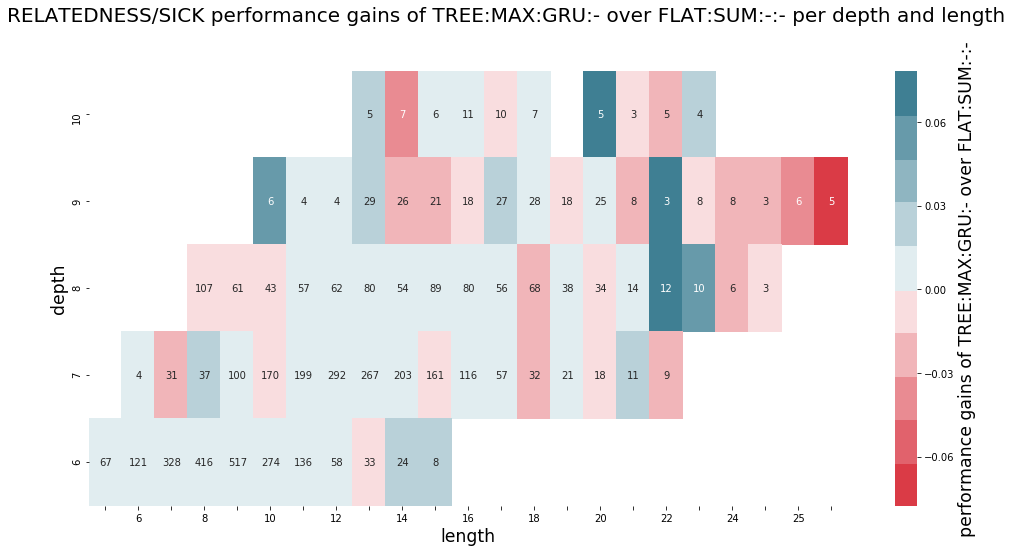

In [44]:
_filter = [True] * len(df_scores_data_filtered)
#_filter = (df_scores_data['depth'] <= 8) 
grouped = df_scores_data_filtered[_filter].groupby(['depth', 'length'])['errors/DIF']
#df_length_depth = df_scores_data.groupby(['depth', 'length'])['errors/DIF'].mean().unstack('length').sort_index(ascending=False)
#df_length_depth_count = df_scores_data_filtered.groupby(['depth', 'length'])['errors/DIF'].count()
grouped_mean = grouped.mean()
grouped_count = grouped.count()
#display(grouped_count)

if task == 'SENTIMENT/IMDB':
    min_group_count = 25
    figsize=(20,10)
else:
    min_group_count = 3
    figsize=(17,8)
print('min_group_count: %i' % min_group_count)
_filter = (grouped_count < min_group_count)

#display(grouped_count)
counts_sum_all = grouped_count.sum()
print('counts_sum_all:\t%i' % counts_sum_all)
grouped_mean.drop(grouped_mean[_filter].index, inplace=True)
grouped_count.drop(grouped_count[_filter].index, inplace=True)
counts_sum_dropped = counts_sum_all - grouped_count.sum()
print('counts_sum_dropped:\t%i' % counts_sum_dropped)
print('counts_sum_remaining:\t%i' % grouped_count.sum())
#grouped_mean[_filter] = np.nan
#grouped_mean = grouped_mean.dropna(how='all')
#grouped_count[_filter] = np.nan
#display(grouped_count)
#grouped_count = grouped_count.dropna(how='all')


#display(grouped_mean)
df_length_depth = grouped_mean.unstack('length').sort_index(ascending=False)
#display(df_length_depth)
df_length_depth_count = grouped_count.unstack('length').sort_index(ascending=False).astype('Int64')
#display(df_length_depth_count)

#display(df_length_depth_count)
#.filter(lambda x: x['B'].mean() > 3.)


#df_length_depth
#uniform_data = np.random.rand(10, 12)
fig, ax = plt.subplots(figsize=figsize)
cmap = sns.color_palette("coolwarm", 10)
#cmap = sns.color_palette("RdBu_r", 7)
cmap = sns.diverging_palette(10, 220, sep=10, n=10)
#annot = None
annot = df_length_depth_count.values
#annot[annot >= 10] = 'x'
#lable_text = 'performance gains of RecNN over RNN'
lable_text = 'performance gains of %s over %s' % (ms[0], ms[1])
sns.heatmap(df_length_depth, annot=annot, ax=ax, cmap=cmap, fmt='', center=0.0, cbar_kws={'label': lable_text})
#ax.set_title('RE performance gains of RecNN over RNN per depth and length', y=1.1, x=0.55, fontsize=20)#'xx-large')
ax.set_title('%s %s per depth and length' % (task, lable_text), y=1.1, x=0.55, fontsize=20)#'xx-large')
ax.xaxis.label.set_fontsize('xx-large')
ax.yaxis.label.set_fontsize('xx-large')
# resize colorbor label 
fig.axes[-1].yaxis.label.set_size('xx-large')
# disable every second tick
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

#df_length_depth
images = {}
images['re_length_depth'] = fig
print_images(images=images, path=image_path)

In [45]:
## Correlation of different data features (elength, depth, ...) with errors (per model and dif)

## Second table shows correlation when grouped by respective data feature

print(task)
# 2-sentence tasks:
# RELATEDNESS
# structural differences have impact on performance for both models:
#   RNN: depnds on lengt and not on depth (just weakly significant)
#   TREE: depends on depth, but not on length 
# TREE still preforms better on higher depth-differences 

#df_scores_data_sorted_filtered = 

def check_correlation(df):
    rows = []
    rows_grouped = []
    group_cols = ['depth', 'length', 'overlap_gold_dif']
    for col in ['depth', 'length', 'scores_gold', 'overlap_gold_dif', 'depth_length_ratio', 'depth_length_product', 'depth_length_sum', 'length_cut', 'depth_cut']:
        for suffix in ['_difabs', '']:
            _d = col + suffix
            if _d in group_cols and _d in df:
                grouped = df.groupby(_d)
            else:
                grouped = None

            if _d in df:
                #print(_d)
                for m in ms + ['DIF']:
                    #print('%s\t%s' % (_d, 'errors/' + m))
                    pers = pearsonr(df['errors/' + m], df[_d])
                    #print(pers)
                    rows.append(('errors/' + m, _d) + pers)
                    if grouped is not None:
                        grouped_mean = grouped.mean().reset_index()
                        #print(m)
                        #print(grouped_mean['errors/' + m])
                        #print(grouped_mean[_d])
                        pers_grouped = pearsonr(grouped_mean['errors/' + m], grouped_mean[_d])
                        rows_grouped.append(('errors/' + m, _d) + pers_grouped + (len(grouped), ))#str(list(grouped.groups)) if len(grouped.groups) < 30 else '...'))
    #pd.DataFrame(rows, columns=('m', 'd' , 'corr', 'p_value')).set_index(['m', 'd'])
    display_colored(pd.DataFrame(rows, columns=('m', 'd' , 'corr', 'p_value')).set_index(['m', 'd']), columns=None, columns_inverted=['p_value'])
    #pd.DataFrame(rows_grouped, columns=('m', 'd' , 'corr', 'p_value', 'count')).set_index(['m', 'd'])
    display_colored(pd.DataFrame(rows_grouped, columns=('m', 'd' , 'corr', 'p_value', 'count')).set_index(['m', 'd']), columns=None, columns_inverted=['p_value'])
    
#check_correlation(df_scores_data_filtered[(df_scores_data_filtered['length'] <= 500) & (df_scores_data_filtered['depth'] <= 50)])
check_correlation(df_scores_data_filtered)

RELATEDNESS/SICK


,,corr,p_value
m,d,,
errors/TREE:MAX:GRU:-,depth_difabs,0.0465,0.0011
errors/FLAT:SUM:-:-,depth_difabs,0.0295,0.0387
errors/DIF,depth_difabs,-0.0197,0.1666
errors/TREE:MAX:GRU:-,depth,0.0594,0.0000
errors/FLAT:SUM:-:-,depth,0.0446,0.0018
errors/DIF,depth,-0.0165,0.2483
errors/TREE:MAX:GRU:-,length_difabs,0.0261,0.0672
errors/FLAT:SUM:-:-,length_difabs,-0.0128,0.3677
errors/DIF,length_difabs,-0.0479,0.0008


,,corr,p_value,count
m,d,,,
errors/TREE:MAX:GRU:-,depth,0.7160,0.0301,9
errors/FLAT:SUM:-:-,depth,0.7813,0.0129,9
errors/DIF,depth,0.7623,0.0169,9
errors/TREE:MAX:GRU:-,length,-0.0897,0.6630,26
errors/FLAT:SUM:-:-,length,-0.3088,0.1248,26
errors/DIF,length,-0.4510,0.0207,26
errors/TREE:MAX:GRU:-,overlap_gold_dif,-0.2272,0.0000,2062
errors/FLAT:SUM:-:-,overlap_gold_dif,-0.2566,0.0000,2062
errors/DIF,overlap_gold_dif,-0.0502,0.0225,2062


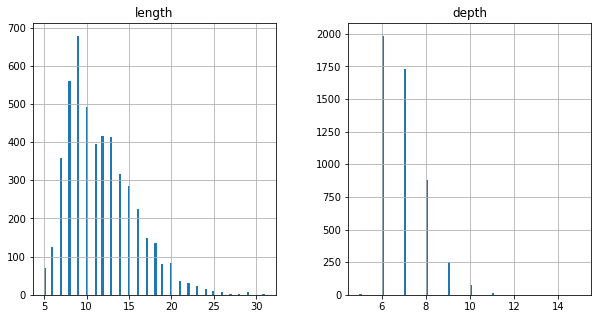

In [46]:
# Length and Depth distribution for the dataset

fig, axes = plt.subplots(1,2, figsize=(10, 5))
df_scores_data_sorted[df_scores_data_sorted['length'] <= 500].hist(column='length', bins=100, ax=axes[0], label='length')
df_scores_data_sorted[df_scores_data_sorted['depth'] <= 50].hist(column='depth', bins=100, ax=axes[1], label='depth')
#ax.yaxis.label.set_text('length')
#ax.yaxis.label.set_fontsize('x-large')
images['imdb_length_depth'] = fig
print_images(images=images, path=image_path)

In [47]:
## Check perfromance advantages for different data subsets (depending on length and depth)

## Assume, in ms[0] is the RecNN model, and in ms[1] the RNN
filter_col = {ms[1]: 'length', ms[0]: 'depth'}
filter_val = {'length': 500, 'depth': 50}
rows = []
filtered_errors = {}
for cut in [True, False]:
    for m in ms:
        _filter = df_scores_data_sorted[filter_col[m]] <= filter_val[filter_col[m]]

        if cut:
            _filter = ~_filter
        _df_filtered = df_scores_data_sorted[_filter]['errors/' + m]
        filtered_errors[(m, cut)] = _df_filtered
        _mean = _df_filtered.mean()
        rows.append((m, cut, _mean, 1.0 -_mean, len(_df_filtered)))
display(pd.DataFrame(rows, columns=('model','cut', 'errors', 'acc', 'nbr')).set_index(keys=['model','cut']))

print(st.ttest_ind(filtered_errors[(ms[0], False)], filtered_errors[(ms[1], False)]))
print(st.ttest_ind(filtered_errors[(ms[0], True)], filtered_errors[(ms[1], False)]))
print(st.ttest_ind(filtered_errors[(ms[0], True)], filtered_errors[(ms[1], True)]))
print(st.ttest_ind(1.0-df_scores_data_sorted['errors/%s' % ms[0]], 1.0-df_scores_data_sorted['errors/%s' % ms[1]]))
print((1.0-df_scores_data_sorted['errors/%s' % ms[0]]).mean())
print((1.0-df_scores_data_sorted['errors/%s' % ms[1]]).mean())

,,errors,acc,nbr
model,cut,,,
TREE:MAX:GRU:-,True,NaN,NaN,0
FLAT:SUM:-:-,True,NaN,NaN,0
TREE:MAX:GRU:-,False,0.111464,0.888536,4927
FLAT:SUM:-:-,False,0.114100,0.885900,4927


Ttest_indResult(statistic=-1.3062664386516705, pvalue=0.19149246125957675)
Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=1.3063070640834014, pvalue=0.19147865154517635)
0.8885357
0.8859004


In [48]:
## Mean scores for certain data subset (restricted by length) per model

for m in ms:
    print(m)
    print(df_scores_data_sorted[df_scores_data_sorted['length'] <= 500]['errors/' + m].mean())

TREE:MAX:GRU:-
0.11146433
FLAT:SUM:-:-
0.11409955


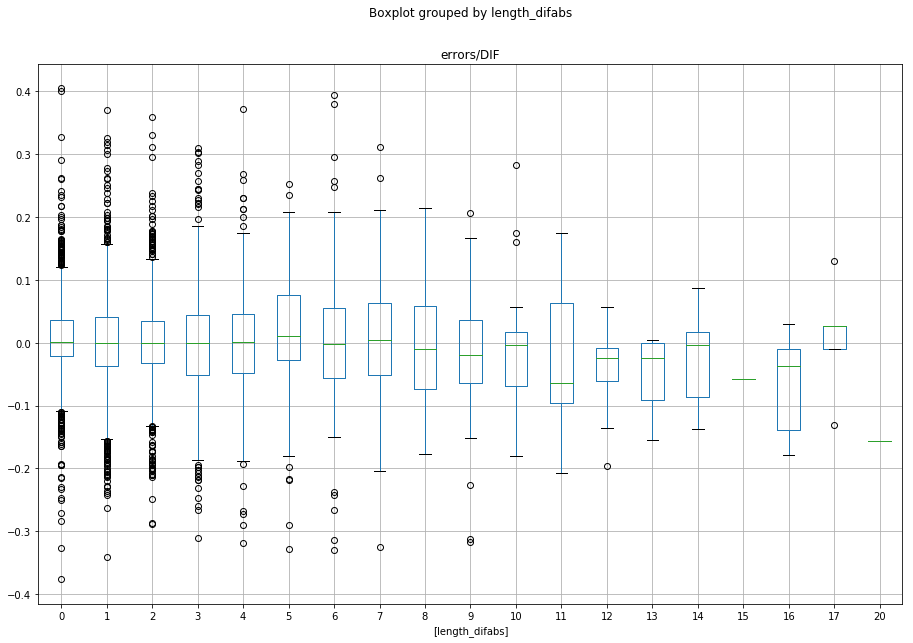

In [49]:
## Check influence of length difference of sentences for two-sentence tasks (RP, RTE)

if 'length_difabs' in df_scores_data_sorted:
    ax = df_scores_data_sorted.boxplot(by=['length_difabs'], column=['errors/DIF'], figsize=(15,10))

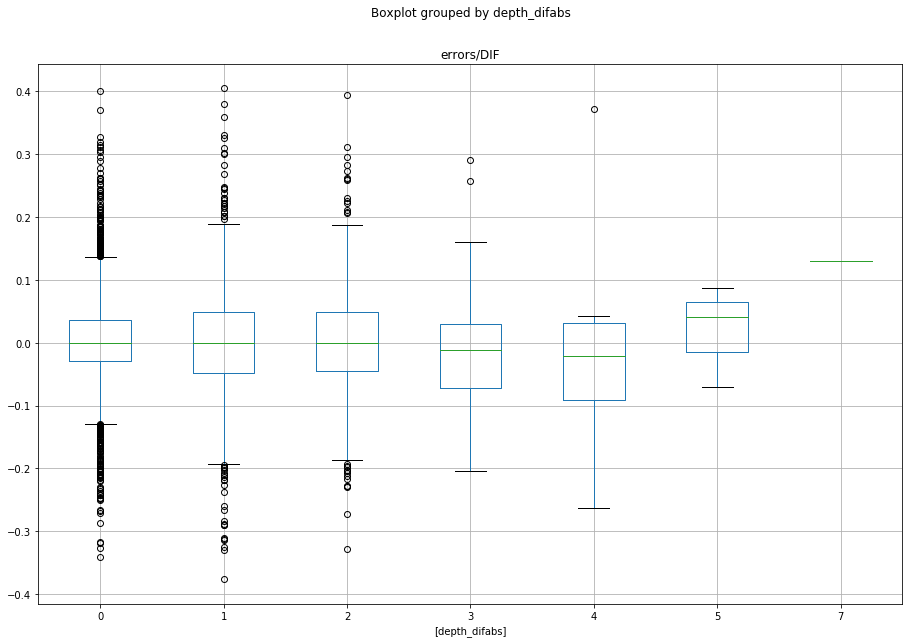

In [50]:
## Check influence of depth difference of sentences for two-sentence tasks (RP, RTE)

if 'depth_difabs' in df_scores_data_sorted:
    ax = df_scores_data_sorted.boxplot(by=['depth_difabs'], column=['errors/DIF'], figsize=(15,10))

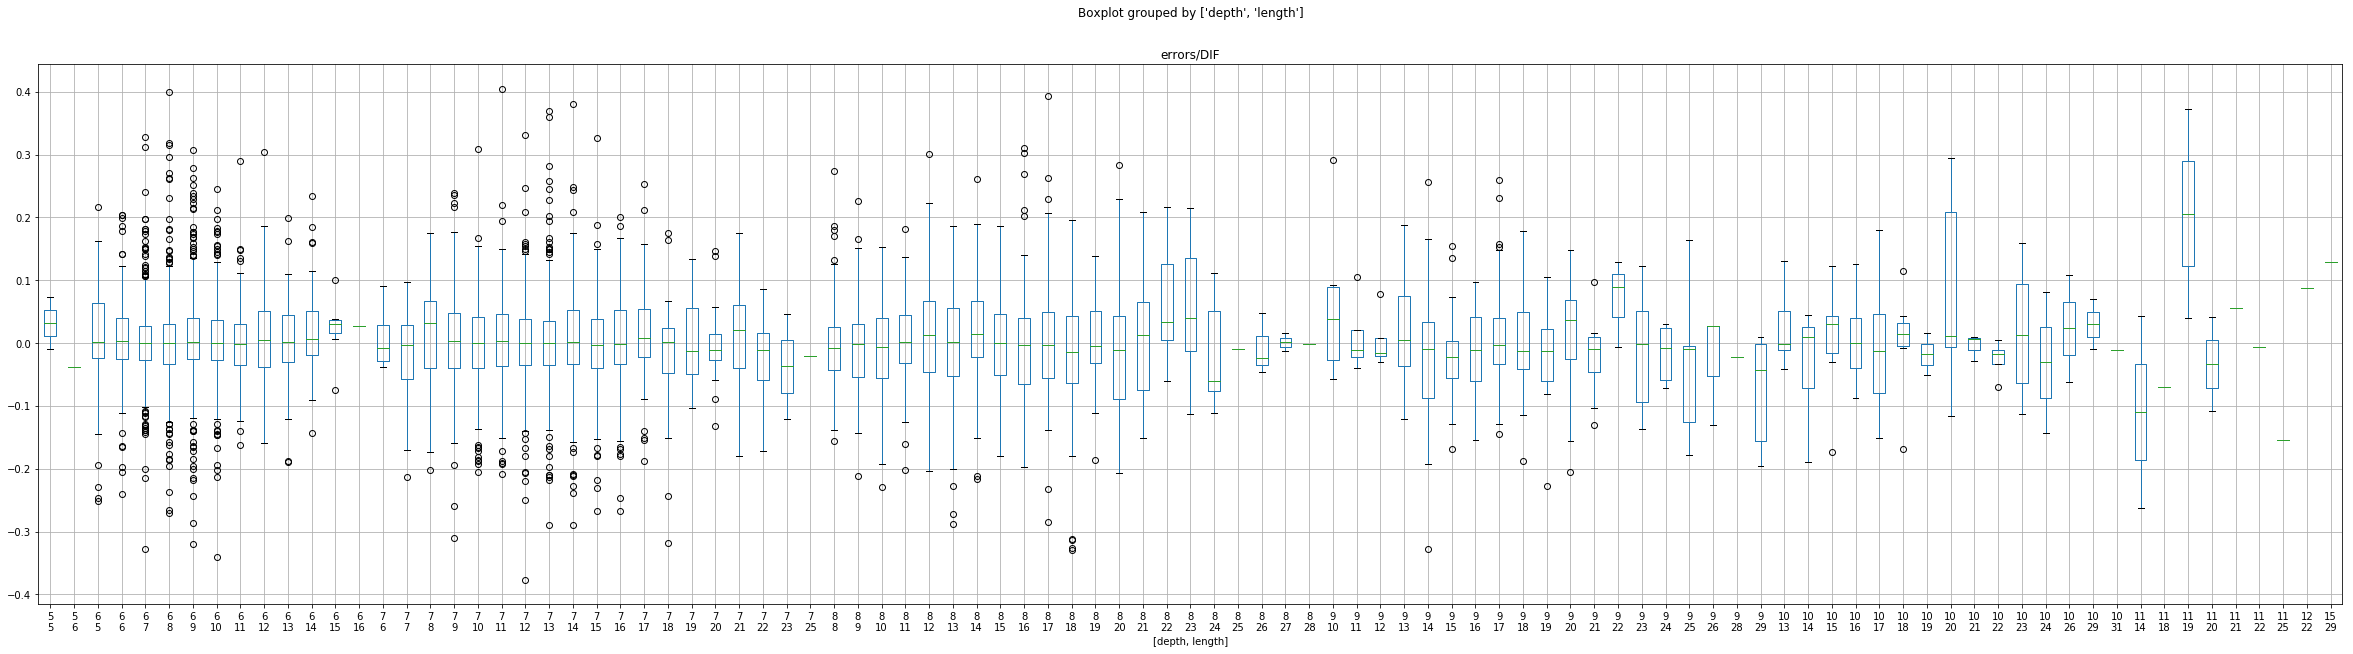

In [51]:
## Check influence of depth and length (all combinations)

col = 'length_max'
col_b = 'errors/DIF'
ax = df_scores_data_sorted.boxplot(by=['depth', 'length'], column=['errors/DIF'], figsize=(40,10))
format_xticks(ax, label_part_types=('pass', 'pass'))

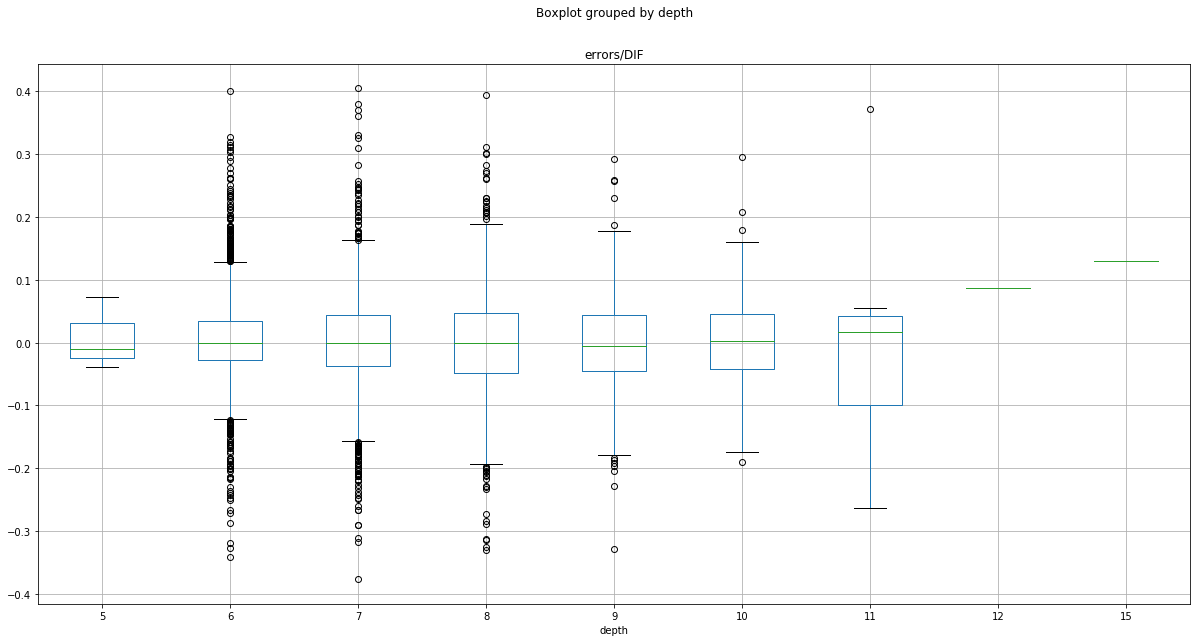

In [52]:
#df_scores_data_sorted[-100:]
#df_scores_data_sorted[-20:].hist(column='depth_max', bins=100, figsize=(20,5))
#df_scores_data_sorted.plot.scatter(x='length_max', y=('errors', 'DIF'), figsize=(15,10))
ax = df_scores_data_sorted.boxplot(by='depth', column=['errors/DIF'], figsize=(20,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f957ebdecd0>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9581d4c7d0>]],
      dtype=object)

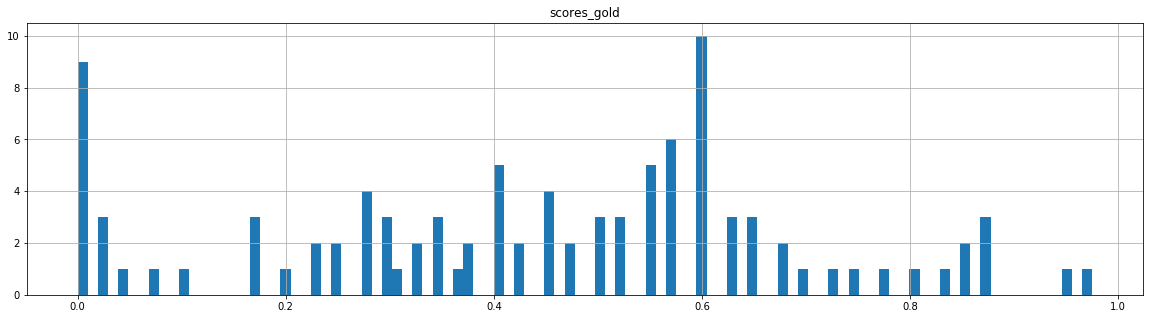

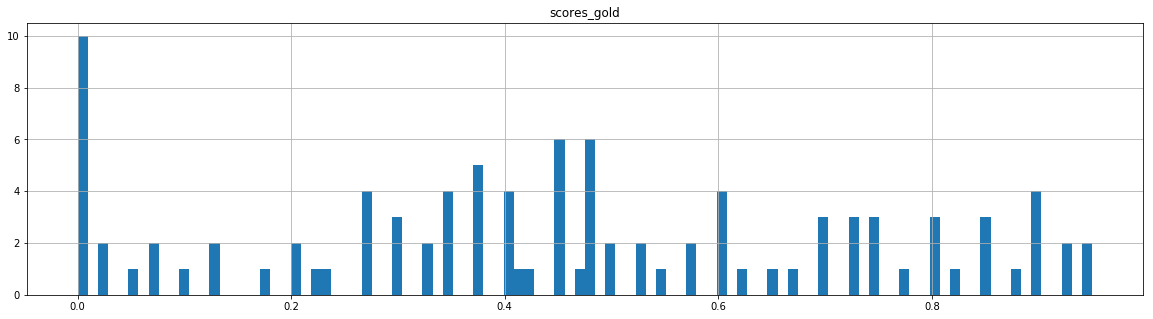

In [53]:
## distibution of scores_gold for best records (RecNN) and worst; interesting just for regression task (RP)

display(df_scores_data_sorted[-100:].hist(column='scores_gold', bins=100, figsize=(20,5)))
display(df_scores_data_sorted[:100].hist(column='scores_gold', bins=100, figsize=(20,5)))

# STOP